# Projet 5 : Segmentez des clients d'un site e-commerce

Notebook d'analyse exploratoire des données.

*Olist* souhaite que vous fournissiez à ses équipes d'e-commerce une **segmentation des clients** qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de **comprendre les différents types d’utilisateurs** grâce à leur comportement et à leurs données personnelles.

Vous devrez **fournir à l’équipe marketing une description actionable** de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une **proposition de contrat de maintenance** basée sur une analyse de la stabilité des segments au cours du temps.


# Summary
 - <a href="#C1">Import and settings</a>
      - <a href="#C1.1">Import required items</a>
      - <a href="#C1.2">Settings</a>
 - <a href="#C2">Functions</a>
 - <a href="#C3">Analyze and clean data</a>
      - <a href="#C3.1">Customer</a>
      - <a href="#C3.2">Geolocation</a>
      - <a href="#C3.3">Items</a>
      - <a href="#C3.4">Payments</a>
      - <a href="#C3.5">Reviews</a>
      - <a href="#C3.6">Orders</a>
      - <a href="#C3.7">Products</a>
      - <a href="#C3.8">Sellers</a>
      - <a href="#C3.9">Translation</a>
 - <a href="#C4">Build a unique dataset</a>
      - <a href="#C4.1">Customers and location</a>
      - <a href="#C4.2">Sellers and location</a>
      - <a href="#C4.3">Products and translation</a>
      - <a href="#C4.4">Orders and customers</a>
      - <a href="#C4.5">Orders and items</a>
      - <a href="#C4.6">Orders and reviews</a>
      - <a href="#C4.7">Orders and payments</a>
      - <a href="#C4.8">Orders and sellers</a>
      - <a href="#C4.9">Create features</a>
      - <a href="#C4.10">Final dataset</a>

# <a name="C1"> Import and settings
## <a name="C1.1"> Import required items

In [4]:
# Use code formatting tool
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [5]:
# Import required librairies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.collections import LineCollection
from mpl_toolkits import mplot3d

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
)
from sklearn.compose import ColumnTransformer
from sklearn import (
    cluster,
    metrics,
    manifold,
    decomposition,
    ensemble,
)
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, cut_tree

import datetime

<IPython.core.display.Javascript object>

In [6]:
# Import data files in DataFrames

# Customers
data_customer = pd.read_csv("olist_customers_dataset.csv")
# Geolocation
data_geoloc = pd.read_csv("olist_geolocation_dataset.csv")
# Order items
data_items = pd.read_csv("olist_order_items_dataset.csv")
# Order payments
data_payments = pd.read_csv("olist_order_payments_dataset.csv")
# Order reviews
data_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
# Orders
data_orders = pd.read_csv("olist_orders_dataset.csv")
# Products
data_products = pd.read_csv("olist_products_dataset.csv")
# Sellers
data_sellers = pd.read_csv("olist_sellers_dataset.csv")
# Translation
data_translation = pd.read_csv("product_category_name_translation.csv")

<IPython.core.display.Javascript object>

## <a name="C1.2"> Settings

In [7]:
# Set the results display
pd.set_option("display.max_rows", 70)
pd.set_option("display.max_columns", 100)
pd.options.display.float_format = "{:,.4f}".format

<IPython.core.display.Javascript object>

In [8]:
# General settings
random = 42

<IPython.core.display.Javascript object>

# <a name="C2"> Functions

In [9]:
# Function to create a 3D projection plot
def display_3D(X_trans, x, y, z):
    """
    This function allows to create a 3 dimension plot in order to display a data projection
    done using a feature reduction method (PCA, kPCA, TSNE, lle...).

    Parameters
    ----------
    X_trans : 3 dimensions (minimum) array
    x : int, X_trans column to be used for the x axis
    y : int, X_trans column to be used for the y axis
    z : int, X_trans column to be used for the z axis

    Return
    ------
    3D plot

    """
    fig = plt.figure(figsize=[7, 7])
    ax = plt.axes(projection="3d")

    ax.plot(
        X_trans[:, x],
        X_trans[:, y],
        X_trans[:, z],
        ".",
    )
    plt.show

<IPython.core.display.Javascript object>

In [10]:
# Function to create a 3D projection plot
def display_clusters_3D(X_trans, my_cluster, x, y, z):
    """
    This function allows to create a 3 dimension plot in order to display a data projection
    done using a feature reduction method (PCA, kPCA, TSNE, lle...).
    In case there is a clustering, display the values using colors accordingly.

    Parameters
    ----------
    X_trans : 3 dimensions (minimum) array
    my_cluster : 1 dimension array representing the cluster for each individual
    x : int, X_trans column to be used for the x axis
    y : int, X_trans column to be used for the y axis
    z : int, X_trans column to be used for the z axis

    Return
    ------
    3D plot

    """
    fig = plt.figure(figsize=[7, 7])
    ax = plt.axes(projection="3d")

    # Set the colors
    color = cm.brg(np.linspace(0, 1, np.max(my_cluster) - np.min(my_cluster) + 1))

    for i in range(np.min(my_cluster), np.max(my_cluster) + 1):
        ax.plot(
            X_trans[my_cluster == i][:, x],
            X_trans[my_cluster == i][:, y],
            X_trans[my_cluster == i][:, z],
            ".",
            color=color[i],
            label=i,
        )
        ax.text(
            X_trans[my_cluster == i][:, x][0],
            X_trans[my_cluster == i][:, y][0],
            X_trans[my_cluster == i][:, z][0],
            str(i),
            color="black",
            size=16,
        )
        plt.legend(bbox_to_anchor=(1.2, 0.5), loc="right")
        plt.show

<IPython.core.display.Javascript object>

In [11]:
# Function to plot a dendrogram in order to figure out how the relevant number of clusters
def plot_dendrogram(Z, names, p):
    """
    This function allows to create a dendrogram plot in order to figure out how the relevant number of clusters for the tested dataset.

    Parameters
    ----------
    Z : hierarchical clustering method to be used
    names : dataframe, data to be tested
    p : int, maximum number of clusters to display in the plot

    Return
    ------
    plot

    """
    plt.figure(figsize=(10, 7))
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("distance")
    dendrogram(
        Z,
        truncate_mode="lastp",  # show only the last p merged clusters
        p=p,  # show only the last p merged clusters
        show_leaf_counts=True,  # numbers in brackets are counts
        labels=names,
        orientation="top",
    )
    plt.show()

<IPython.core.display.Javascript object>

# <a name="C3"> Analyze and clean data

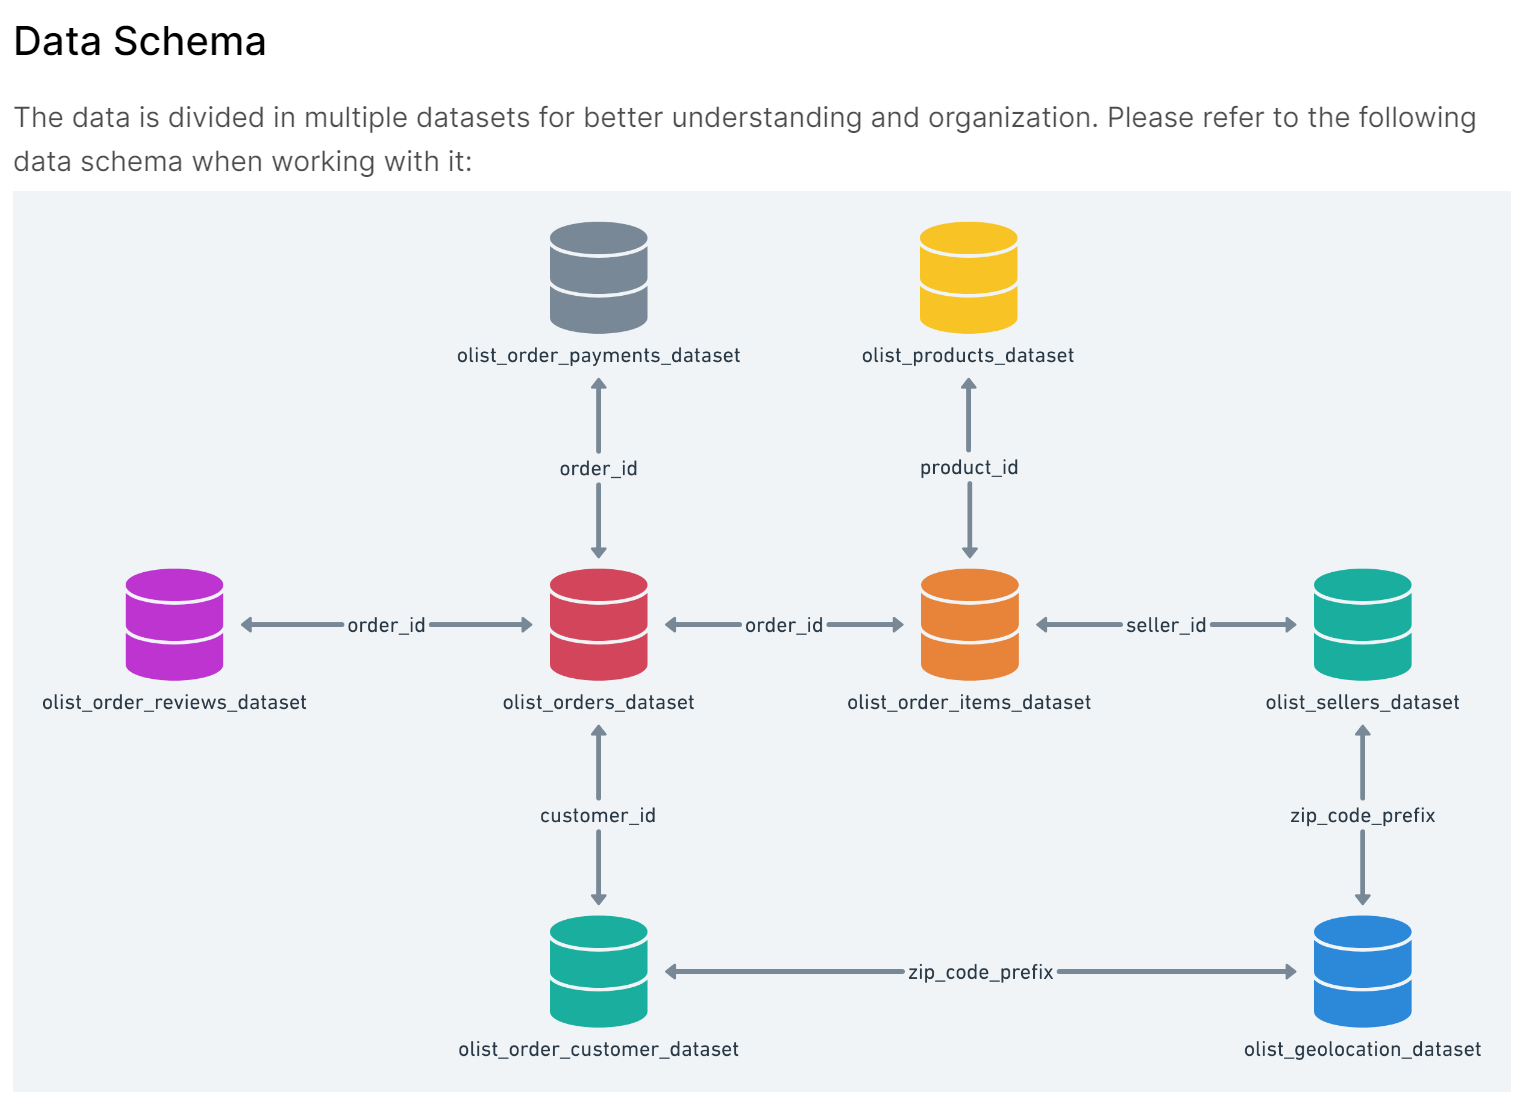

## <a name="C3.1"> Customer

In [12]:
# Data on clients IDs and location
# Customer_id is used to link with the orders
data_customer

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


<IPython.core.display.Javascript object>

In [13]:
# Check if there are outlier values
data_customer.describe()

,customer_zip_code_prefix
count,"99,441.0000"
mean,"35,137.4746"
std,"29,797.9390"
min,"1,003.0000"
25%,"11,347.0000"
50%,"24,416.0000"
75%,"58,900.0000"
max,"99,990.0000"


<IPython.core.display.Javascript object>

In [14]:
# Check if there are missing values per column
round(data_customer.isnull().sum() / len(data_customer) * 100, 2)

customer_id                0.0000
customer_unique_id         0.0000
customer_zip_code_prefix   0.0000
customer_city              0.0000
customer_state             0.0000
dtype: float64

<IPython.core.display.Javascript object>

In [15]:
# Check if there are doublons in customer_id column
clean_customer = data_customer.drop_duplicates(subset="customer_id")
print("Customer ID doublon :", len(data_customer) - len(clean_customer))

Customer ID doublon : 0


<IPython.core.display.Javascript object>

In [16]:
# Check how many clients have passed several orders by checking doublons in customer_unique_id column
total_customer = len(clean_customer["customer_unique_id"].unique())
test = clean_customer.drop_duplicates(subset="customer_unique_id", keep=False)
print("Total number of customers :", total_customer)
print("Customer with 1 order :", len(test))
print("Customer with multiple orders :", total_customer - len(test))

Total number of customers : 96096
Customer with 1 order : 93099
Customer with multiple orders : 2997


<IPython.core.display.Javascript object>

In [17]:
# Check if there are different zip code for the same customer
# Extract unique customer and their zip code
check_zip = clean_customer[["customer_unique_id", "customer_zip_code_prefix"]]
# remove doublons due to several orders
check_zip = check_zip.drop_duplicates(
    subset=["customer_unique_id", "customer_zip_code_prefix"]
)
# Sort by unique customer
check_zip = check_zip.sort_values(by="customer_unique_id")
# and display the doublons
check_zip[check_zip.duplicated(subset=["customer_unique_id"], keep=False)]

,customer_unique_id,customer_zip_code_prefix
72451,004b45ec5c64187465168251cd1c9c2f,57055
87012,004b45ec5c64187465168251cd1c9c2f,57035
61403,0058f300f57d7b93c477a131a59b36c3,40731
36269,0058f300f57d7b93c477a131a59b36c3,41370
45307,012452d40dafae4df401bced74cdb490,3220
...,...,...
12695,fb490a070c5dbc385afadcf0e56270bd,21040
84770,fd09c64a101e3eff4adbca1b28552514,8070
69820,fd09c64a101e3eff4adbca1b28552514,8542
76055,fe3e52de024b82706717c38c8e183084,72306


<IPython.core.display.Javascript object>

In [18]:
# Let's keep only the first zip code for each customer
check_zip = check_zip.drop_duplicates(subset=["customer_unique_id"], keep="first")
len(check_zip)
# OK

96096

<IPython.core.display.Javascript object>

In [19]:
# Let's correct the customer zip codes by the ones from the list we just cleaned
clean_customer = clean_customer.drop(columns="customer_zip_code_prefix")
clean_customer = pd.merge(
    clean_customer, check_zip, on="customer_unique_id", how="left"
)
len(clean_customer)

99441

<IPython.core.display.Javascript object>

In [20]:
# Let's count the number of orders a unique customer has made
count_orders = clean_customer.pivot_table(
    index="customer_unique_id", values="customer_id", aggfunc="count"
).reset_index()
count_orders.rename(
    {"customer_id": "order_nb"},
    axis=1,
    inplace=True,
)
count_orders

,customer_unique_id,order_nb
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,1
96092,fffea47cd6d3cc0a88bd621562a9d061,1
96093,ffff371b4d645b6ecea244b27531430a,1
96094,ffff5962728ec6157033ef9805bacc48,1


<IPython.core.display.Javascript object>

In [21]:
# Merge with the customer dataset
clean_customer = clean_customer.merge(count_orders, how="left", on="customer_unique_id")
clean_customer

,customer_id,customer_unique_id,customer_city,customer_state,customer_zip_code_prefix,order_nb
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,SP,14409,1
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo,SP,9790,1
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,sao paulo,SP,1151,1
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,mogi das cruzes,SP,8775,1
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,campinas,SP,13056,1
...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,sao paulo,SP,3937,1
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,taboao da serra,SP,6764,1
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,fortaleza,CE,60115,1
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,canoas,RS,92120,1


<IPython.core.display.Javascript object>

In [22]:
# Let's keep the useful columns only
clean_customer = clean_customer[
    ["customer_id", "customer_unique_id", "customer_zip_code_prefix", "order_nb"]
]

<IPython.core.display.Javascript object>

## <a name="C3.2"> Geolocation

In [23]:
# geolocation details
data_geoloc

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.5456,-46.6393,sao paulo,SP
1,1046,-23.5461,-46.6448,sao paulo,SP
2,1046,-23.5461,-46.6430,sao paulo,SP
3,1041,-23.5444,-46.6395,sao paulo,SP
4,1035,-23.5416,-46.6416,sao paulo,SP
...,...,...,...,...,...
1000158,99950,-28.0686,-52.0107,tapejara,RS
1000159,99900,-27.8771,-52.2249,getulio vargas,RS
1000160,99950,-28.0719,-52.0147,tapejara,RS
1000161,99980,-28.3889,-51.8469,david canabarro,RS


<IPython.core.display.Javascript object>

In [24]:
# Check if there are outlier values
data_geoloc.describe()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
count,"1,000,163.0000","1,000,163.0000","1,000,163.0000"
mean,"36,574.1665",-21.1762,-46.3905
std,"30,549.3357",5.7159,4.2697
min,"1,001.0000",-36.6054,-101.4668
25%,"11,075.0000",-23.6035,-48.5732
50%,"26,530.0000",-22.9194,-46.6379
75%,"63,504.0000",-19.9796,-43.7677
max,"99,990.0000",45.0659,121.1054


<IPython.core.display.Javascript object>

In [25]:
# Check if there are missing values per column
round(data_geoloc.isnull().sum() / len(data_geoloc) * 100, 2)

geolocation_zip_code_prefix   0.0000
geolocation_lat               0.0000
geolocation_lng               0.0000
geolocation_city              0.0000
geolocation_state             0.0000
dtype: float64

<IPython.core.display.Javascript object>

In [26]:
# Check if there are doublons in geolocation_zip_code_prefix column
clean_geoloc = data_geoloc.drop_duplicates(subset="geolocation_zip_code_prefix")
print("Initial number of location :", len(data_geoloc))
print("Location doublon? :", len(data_geoloc) - len(clean_geoloc))
print("Number of unique location :", len(clean_geoloc))

Initial number of location : 1000163
Location doublon? : 981148
Number of unique location : 19015


<IPython.core.display.Javascript object>

In [27]:
# We only keep the first values for each zip code
clean_geoloc

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.5456,-46.6393,sao paulo,SP
1,1046,-23.5461,-46.6448,sao paulo,SP
3,1041,-23.5444,-46.6395,sao paulo,SP
4,1035,-23.5416,-46.6416,sao paulo,SP
5,1012,-23.5478,-46.6354,são paulo,SP
...,...,...,...,...,...
999774,99955,-28.1076,-52.1440,vila langaro,RS
999780,99970,-28.3451,-51.8769,ciriaco,RS
999786,99910,-27.8635,-52.0848,floriano peixoto,RS
999803,99920,-27.8587,-52.3004,erebango,RS


<IPython.core.display.Javascript object>

## <a name="C3.3"> Items

In [28]:
# price and freight value per item
data_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9000,13.2900
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9000,19.9300
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0000,17.8700
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.9900,12.7900
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.9000,18.1400
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.9900,43.4100
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.0000,36.5300
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.9000,16.9500
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.9900,8.7200


<IPython.core.display.Javascript object>

In [29]:
# Check if there are outlier values
data_items.describe()

,order_item_id,price,freight_value
count,"112,650.0000","112,650.0000","112,650.0000"
mean,1.1978,120.6537,19.9903
std,0.7051,183.6339,15.8064
min,1.0000,0.8500,0.0000
25%,1.0000,39.9000,13.0800
50%,1.0000,74.9900,16.2600
75%,1.0000,134.9000,21.1500
max,21.0000,"6,735.0000",409.6800


<IPython.core.display.Javascript object>

In [30]:
# Check if there are missing values per column
round(data_items.isnull().sum() / len(data_items) * 100, 2)

order_id              0.0000
order_item_id         0.0000
product_id            0.0000
seller_id             0.0000
shipping_limit_date   0.0000
price                 0.0000
freight_value         0.0000
dtype: float64

<IPython.core.display.Javascript object>

In [31]:
# Check the number of orders
len(data_items["order_id"].unique())
# There is a gap if we compare with the number of orders in the customer table

98666

<IPython.core.display.Javascript object>

In [32]:
# Check if there are doublons
# We can have multiple products in one order. The column order_item_id is a sequence of the number of products in the order
clean_items = data_items.drop_duplicates(
    subset=["order_id", "order_item_id", "product_id"]
)
print("Initial number of items :", len(data_items))
print("Items doublon? :", len(data_items) - len(clean_items))
print("Number of unique items :", len(clean_items))

Initial number of items : 112650
Items doublon? : 0
Number of unique items : 112650


<IPython.core.display.Javascript object>

In [33]:
# Let's count the number of items per order
count_items_per_order = clean_items.pivot_table(
    index="order_id", values="order_item_id", aggfunc="count"
).reset_index()
count_items_per_order.rename(
    {"order_item_id": "items_nb"},
    axis=1,
    inplace=True,
)
count_items_per_order

,order_id,items_nb
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1
2,000229ec398224ef6ca0657da4fc703e,1
3,00024acbcdf0a6daa1e931b038114c75,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,1
98662,fffcd46ef2263f404302a634eb57f7eb,1
98663,fffce4705a9662cd70adb13d4a31832d,1
98664,fffe18544ffabc95dfada21779c9644f,1


<IPython.core.display.Javascript object>

In [34]:
# Merge with the items dataset
clean_items = clean_items.merge(count_items_per_order, how="left", on="order_id")
clean_items["items_nb"].value_counts()

1     88863
2     15032
3      3966
4      2020
6      1188
5      1020
7       154
10       80
8        64
12       60
11       44
20       40
15       30
14       28
9        27
21       21
13       13
Name: items_nb, dtype: int64

<IPython.core.display.Javascript object>

In [35]:
# Let's remove columns we don't need
clean_items = clean_items.drop(columns=["order_item_id", "shipping_limit_date"])
clean_items

,order_id,product_id,seller_id,price,freight_value,items_nb
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9000,13.2900,1
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.9000,19.9300,1
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.0000,17.8700,1
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.9900,12.7900,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.9000,18.1400,1
...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,299.9900,43.4100,1
112646,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,350.0000,36.5300,1
112647,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,99.9000,16.9500,1
112648,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,55.9900,8.7200,1


<IPython.core.display.Javascript object>

## <a name="C3.4"> Payments

In [36]:
# Payments type, schedule and amount per order
data_payments

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.3300
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.3900
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.7100
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.7800
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.4500
...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.3100
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.8000
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.7700
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.5400


<IPython.core.display.Javascript object>

In [37]:
# Check if there are outlier values
data_payments.describe()

,payment_sequential,payment_installments,payment_value
count,"103,886.0000","103,886.0000","103,886.0000"
mean,1.0927,2.8533,154.1004
std,0.7066,2.6871,217.4941
min,1.0000,0.0000,0.0000
25%,1.0000,1.0000,56.7900
50%,1.0000,1.0000,100.0000
75%,1.0000,4.0000,171.8375
max,29.0000,24.0000,"13,664.0800"


<IPython.core.display.Javascript object>

In [38]:
# Check if there are missing values per column
round(data_payments.isnull().sum() / len(data_payments) * 100, 2)

order_id               0.0000
payment_sequential     0.0000
payment_type           0.0000
payment_installments   0.0000
payment_value          0.0000
dtype: float64

<IPython.core.display.Javascript object>

In [39]:
# Check the number of orders
len(data_payments["order_id"].unique())
# We have more orders here than in the items table, we'll have to ignore some of them

99440

<IPython.core.display.Javascript object>

In [40]:
# Check if there are doublons
# A customer may pay an order with more than one payment method.
# The column payment_sequential indicates this is a sequence of the number of products in the order
clean_payments = data_payments.drop_duplicates(
    subset=["order_id", "payment_sequential"]
)
print("Initial number of payments :", len(data_payments))
print("Payments doublon? :", len(data_payments) - len(clean_payments))
print("Number of unique Payments :", len(clean_payments))

Initial number of payments : 103886
Payments doublon? : 0
Number of unique Payments : 103886


<IPython.core.display.Javascript object>

In [41]:
# Let's remove columns we'll not be using
clean_payments = clean_payments.drop(columns=["payment_sequential", "payment_value"])
clean_payments

,order_id,payment_type,payment_installments
0,b81ef226f3fe1789b1e8b2acac839d17,credit_card,8
1,a9810da82917af2d9aefd1278f1dcfa0,credit_card,1
2,25e8ea4e93396b6fa0d3dd708e76c1bd,credit_card,1
3,ba78997921bbcdc1373bb41e913ab953,credit_card,8
4,42fdf880ba16b47b59251dd489d4441a,credit_card,2
...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,boleto,1
103882,7b905861d7c825891d6347454ea7863f,credit_card,2
103883,32609bbb3dd69b3c066a6860554a77bf,credit_card,1
103884,b8b61059626efa996a60be9bb9320e10,credit_card,5


<IPython.core.display.Javascript object>

In [42]:
# Let's only keep the total number of payment installments for each order (keep the last payment type if different)
clean_payments = clean_payments.sort_values(
    by=["order_id", "payment_installments"], ascending=False
)
clean_payments = clean_payments.drop_duplicates(subset="order_id")
clean_payments

,order_id,payment_type,payment_installments
1235,fffe41c64501cc87c801fd61db3f6244,credit_card,1
37089,fffe18544ffabc95dfada21779c9644f,credit_card,3
58888,fffce4705a9662cd70adb13d4a31832d,credit_card,3
2776,fffcd46ef2263f404302a634eb57f7eb,boleto,1
69123,fffc94f6ce00a00581880bf54a75a037,boleto,1
...,...,...,...
98711,00042b26cf59d7ce69dfabb4e55b4fd9,credit_card,3
32971,00024acbcdf0a6daa1e931b038114c75,credit_card,2
12393,000229ec398224ef6ca0657da4fc703e,credit_card,5
2499,00018f77f2f0320c557190d7a144bdd3,credit_card,3


<IPython.core.display.Javascript object>

## <a name="C3.5"> Reviews

In [43]:
# clients' reviews per order
data_reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


<IPython.core.display.Javascript object>

In [44]:
# Check if there are outlier values
data_reviews.describe()

,review_score
count,"99,224.0000"
mean,4.0864
std,1.3476
min,1.0000
25%,4.0000
50%,5.0000
75%,5.0000
max,5.0000


<IPython.core.display.Javascript object>

In [45]:
# Check if there are missing values per column
round(data_reviews.isnull().sum() / len(data_reviews) * 100, 2)

review_id                  0.0000
order_id                   0.0000
review_score               0.0000
review_comment_title      88.3400
review_comment_message    58.7000
review_creation_date       0.0000
review_answer_timestamp    0.0000
dtype: float64

<IPython.core.display.Javascript object>

In [46]:
# Check the number of orders
len(data_reviews["order_id"].unique())
# less than the ones we have in the items table because some orders don't have any review which is fine

98673

<IPython.core.display.Javascript object>

In [47]:
# Check if there are doublons
# Is this possible to post multiple review on 1 order?
clean_reviews = data_reviews.drop_duplicates(subset=["order_id"])
print("Initial number of reviews :", len(data_reviews))
print("Reviews doublon? :", len(data_reviews) - len(clean_reviews))
print("Number of unique Payments :", len(clean_reviews))

Initial number of reviews : 99224
Reviews doublon? : 551
Number of unique Payments : 98673


<IPython.core.display.Javascript object>

In [48]:
# Check where there is no comments if there is no title also
mask = data_reviews["review_comment_message"].isnull()
data_reviews.loc[mask, "review_comment_title"].unique()
# Yes, so let's keep both and concatenate them later

array([nan, 'Ótimo', 'Não recebi o produto.', 'Entrega antes do previsto',
       'Recomendo', 'Ótimo ', 'bom', '5', '4', 'Excelente Loja', 'ótimo',
       'Bom', 'recomendo a todos.otima.', 'Excelente', 'Recomendo!',
       'Ótima ', 'Meu produto não chegou', 'Ótimo! ', 'Muito bom',
       'Satisfeito!', '10', 'muito bom', 'Recomendo.',
       'Entrega antes do prazo', 'recomendo', 'super recomendo',
       'Produto errado', 'RECOMENDO', 'SATISFEITO', 'OTIMA',
       'Gostei muito do produto ', 'Ótimo produto', 'recomendo ',
       'Tudo dentro do combinado', 'Maravilhoso!! Super lindo',
       'ótimo produto', 'Super recomendo', 'Bom e barato', 'otimo',
       'SUPER RECOMENDO A LOJA', 'Gostei', 'Ótima loja ', '7',
       'Muito Bom', 'ótimo ', 'FOI RÁPIDO A ENTREGA', 'Entrega rápida',
       'Produto muito bom.', 'recomendado', 'Não quero avaliar',
       'Tudo nos conformes', 'Otima', 'Excelente ', 'Bom ', 'Bom loja',
       'Perfeito', '*****', 'boa', 'Recomendo. muito bom',
     

<IPython.core.display.Javascript object>

In [49]:
# Let's count the number of reviews per order in the initial dataset
count_reviews_per_order = data_reviews.pivot_table(
    index="order_id", values="review_id", aggfunc="count"
).reset_index()
count_reviews_per_order.rename(
    {"review_id": "review_nb"},
    axis=1,
    inplace=True,
)
count_reviews_per_order

,order_id,review_nb
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1
2,000229ec398224ef6ca0657da4fc703e,1
3,00024acbcdf0a6daa1e931b038114c75,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1
...,...,...
98668,fffc94f6ce00a00581880bf54a75a037,1
98669,fffcd46ef2263f404302a634eb57f7eb,1
98670,fffce4705a9662cd70adb13d4a31832d,1
98671,fffe18544ffabc95dfada21779c9644f,1


<IPython.core.display.Javascript object>

In [50]:
# Merge with the initial dataset
data_reviews = data_reviews.merge(count_reviews_per_order, how="left", on="order_id")
data_reviews["review_nb"].value_counts()

1    98126
2     1086
3       12
Name: review_nb, dtype: int64

<IPython.core.display.Javascript object>

In [51]:
# Look at the orders with 2 reviews
data_reviews[data_reviews["review_nb"] == 2].sort_values(
    by=["order_id", "review_creation_date"]
)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_nb
22423,2a74b0559eb58fc1ff842ecc999594cb,0035246a40f520710769010f752e7507,5,NaN,Estou acostumada a comprar produtos pelo barat...,2017-08-25 00:00:00,2017-08-29 21:45:57,2
25612,89a02c45c340aeeb1354a24e7d4b2c1e,0035246a40f520710769010f752e7507,5,NaN,NaN,2017-08-29 00:00:00,2017-08-30 01:59:12,2
22779,ab30810c29da5da8045216f0f62652a2,013056cfe49763c6f66bda03396c5ee3,5,NaN,NaN,2018-02-22 00:00:00,2018-02-23 12:12:30,2
68633,73413b847f63e02bc752b364f6d05ee9,013056cfe49763c6f66bda03396c5ee3,4,NaN,NaN,2018-03-04 00:00:00,2018-03-05 17:02:00,2
854,830636803620cdf8b6ffaf1b2f6e92b2,0176a6846bcb3b0d3aa3116a9a768597,5,NaN,NaN,2017-12-30 00:00:00,2018-01-02 10:54:06,2
...,...,...,...,...,...,...,...,...
27465,5e78482ee783451be6026e5cf0c72de1,ff763b73e473d03c321bcd5a053316e8,3,NaN,Não sei que haverá acontecido os demais chegaram,2017-11-18 00:00:00,2017-11-18 09:02:48,2
41355,39de8ad3a1a494fc68cc2d5382f052f4,ff850ba359507b996e8b2fbb26df8d03,5,NaN,Envio rapido... Produto 100%,2017-08-16 00:00:00,2017-08-17 11:56:55,2
18783,80f25f32c00540d49d57796fb6658535,ff850ba359507b996e8b2fbb26df8d03,5,NaN,"Envio rapido, produto conforme descrito no anu...",2017-08-22 00:00:00,2017-08-25 11:40:22,2
53962,5476dd0eaee7c4e2725cafb011aa758c,ffaabba06c9d293a3c614e0515ddbabc,3,NaN,NaN,2017-12-20 00:00:00,2017-12-21 13:24:55,2


<IPython.core.display.Javascript object>

In [52]:
# Look at the orders with more than 2 reviews
data_reviews[data_reviews["review_nb"] > 2].sort_values(
    by=["order_id", "review_creation_date"]
)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_nb
69438,405eb2ea45e1dbe2662541ae5b47e2aa,03c939fd7fd3b38f8485a0f95798f1f6,3,NaN,Seria ótimo se tivesem entregue os 3 (três) pe...,2018-03-06 00:00:00,2018-03-06 19:50:32,3
8273,b04ed893318da5b863e878cd3d0511df,03c939fd7fd3b38f8485a0f95798f1f6,3,NaN,Um ponto negativo que achei foi a cobrança de ...,2018-03-20 00:00:00,2018-03-21 02:28:23,3
51527,f4bb9d6dd4fb6dcc2298f0e7b17b8e1e,03c939fd7fd3b38f8485a0f95798f1f6,4,NaN,NaN,2018-03-29 00:00:00,2018-03-30 00:29:09,3
44694,67c2557eb0bd72e3ece1e03477c9dff5,8e17072ec97ce29f0e1f111e598b0c85,1,NaN,Entregou o produto errado.,2018-04-07 00:00:00,2018-04-08 22:48:27,3
64510,2d6ac45f859465b5c185274a1c929637,8e17072ec97ce29f0e1f111e598b0c85,1,NaN,Comprei 3 unidades do produto vieram 2 unidade...,2018-04-07 00:00:00,2018-04-07 21:13:05,3
92300,6e4c4086d9611ae4cc0cc65a262751fe,8e17072ec97ce29f0e1f111e598b0c85,1,NaN,"Embora tenha entregue dentro do prazo, não env...",2018-04-14 00:00:00,2018-04-16 11:37:31,3
89360,fb96ea2ef8cce1c888f4d45c8e22b793,c88b1d1b157a9999ce368f218a407141,5,NaN,NaN,2017-07-21 00:00:00,2017-07-26 13:45:15,3
1985,ffb8cff872a625632ac983eb1f88843c,c88b1d1b157a9999ce368f218a407141,3,NaN,NaN,2017-07-22 00:00:00,2017-07-26 13:41:07,3
82525,202b5f44d09cd3cfc0d6bd12f01b044c,c88b1d1b157a9999ce368f218a407141,5,NaN,NaN,2017-07-22 00:00:00,2017-07-26 13:40:22,3
13982,72a1098d5b410ae50fbc0509d26daeb9,df56136b8031ecd28e200bb18e6ddb2e,5,NaN,NaN,2017-02-07 00:00:00,2017-02-10 10:46:09,3


<IPython.core.display.Javascript object>

In [53]:
# Let's keep only the first review per order
data_reviews = data_reviews.sort_values(by=["order_id", "review_creation_date"])
clean_reviews = data_reviews.drop_duplicates(subset=["order_id"])
print("Initial number of reviews :", len(data_reviews))
print("Reviews doublon? :", len(data_reviews) - len(clean_reviews))
print("Number of unique Payments :", len(clean_reviews))

Initial number of reviews : 99224
Reviews doublon? : 551
Number of unique Payments : 98673


<IPython.core.display.Javascript object>

In [54]:
# and remove columns we won't use
clean_reviews = clean_reviews.drop(columns=["review_id"])
clean_reviews

,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_nb
51963,00010242fe8c5a6d1ba2dd792cb16214,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,1
27823,00018f77f2f0320c557190d7a144bdd3,4,NaN,NaN,2017-05-13 00:00:00,2017-05-15 11:34:13,1
4218,000229ec398224ef6ca0657da4fc703e,5,NaN,Chegou antes do prazo previsto e o produto sur...,2018-01-23 00:00:00,2018-01-23 16:06:31,1
38844,00024acbcdf0a6daa1e931b038114c75,4,NaN,NaN,2018-08-15 00:00:00,2018-08-15 16:39:01,1
55676,00042b26cf59d7ce69dfabb4e55b4fd9,5,NaN,Gostei pois veio no prazo determinado .,2017-03-02 00:00:00,2017-03-03 10:54:59,1
...,...,...,...,...,...,...,...
48178,fffc94f6ce00a00581880bf54a75a037,5,NaN,NaN,2018-05-11 00:00:00,2018-05-14 12:53:47,1
21684,fffcd46ef2263f404302a634eb57f7eb,5,NaN,NaN,2018-07-24 00:00:00,2018-07-25 09:25:29,1
37509,fffce4705a9662cd70adb13d4a31832d,5,NaN,NaN,2017-10-29 00:00:00,2017-10-29 21:33:52,1
50462,fffe18544ffabc95dfada21779c9644f,5,NaN,Recebi o produto antes do prazo e corretamente.,2017-08-17 00:00:00,2017-08-18 12:24:05,1


<IPython.core.display.Javascript object>

## <a name="C3.6"> Orders

In [55]:
# Orders details (client, dates, status)
data_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


<IPython.core.display.Javascript object>

In [56]:
# Check if there are outlier values
data_orders.describe()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2018-04-11 10:48:14,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-08 23:38:46,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522


<IPython.core.display.Javascript object>

In [57]:
# Check if there are missing values per column
round(data_orders.isnull().sum() / len(data_orders) * 100, 2)

order_id                        0.0000
customer_id                     0.0000
order_status                    0.0000
order_purchase_timestamp        0.0000
order_approved_at               0.1600
order_delivered_carrier_date    1.7900
order_delivered_customer_date   2.9800
order_estimated_delivery_date   0.0000
dtype: float64

<IPython.core.display.Javascript object>

In [58]:
# Check the number of orders
len(data_orders["order_id"].unique())
# we'll need the items (products) anyway so we'll ignore some orders here

99441

<IPython.core.display.Javascript object>

In [59]:
# Should we keep all orders or filter by their status? Or should we keep the status information in the final data?
data_orders["order_status"].value_counts()

# most of the orders are in delivered status, so this is not relevant to keep this feature

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

<IPython.core.display.Javascript object>

In [60]:
# Check if there are doublons
clean_orders = data_orders.drop_duplicates(subset=["order_id", "customer_id"])
print("Initial number of orders :", len(data_orders))
print("Orders doublon :", len(data_orders) - len(clean_orders))
print("Number of unique Orders :", len(clean_orders))

Initial number of orders : 99441
Orders doublon : 0
Number of unique Orders : 99441


<IPython.core.display.Javascript object>

In [61]:
# Replace the missing delivered customer dates by the estimated dates
mask = clean_orders["order_delivered_customer_date"].isnull()
clean_orders.loc[mask, "order_delivered_customer_date"] = clean_orders.loc[
    mask, "order_estimated_delivery_date"
]

# Let's keep only the useful columns
clean_orders = clean_orders[
    [
        "order_id",
        "customer_id",
        "order_purchase_timestamp",
        "order_delivered_customer_date",
    ]
]

round(clean_orders.isnull().sum() / len(clean_orders) * 100, 2)

order_id                        0.0000
customer_id                     0.0000
order_purchase_timestamp        0.0000
order_delivered_customer_date   0.0000
dtype: float64

<IPython.core.display.Javascript object>

## <a name="C3.7"> Products

In [62]:
# Products details
data_products

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0000,287.0000,1.0000,225.0000,16.0000,10.0000,14.0000
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0000,276.0000,1.0000,"1,000.0000",30.0000,18.0000,20.0000
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0000,250.0000,1.0000,154.0000,18.0000,9.0000,15.0000
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0000,261.0000,1.0000,371.0000,26.0000,4.0000,26.0000
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0000,402.0000,4.0000,625.0000,20.0000,17.0000,13.0000
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0000,67.0000,2.0000,"12,300.0000",40.0000,40.0000,40.0000
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0000,971.0000,1.0000,"1,700.0000",16.0000,19.0000,16.0000
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0000,799.0000,1.0000,"1,400.0000",27.0000,7.0000,27.0000
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0000,156.0000,2.0000,700.0000,31.0000,13.0000,20.0000


<IPython.core.display.Javascript object>

In [63]:
# Check if there are outlier values
data_products.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,"32,341.0000","32,341.0000","32,341.0000","32,949.0000","32,949.0000","32,949.0000","32,949.0000"
mean,48.4769,771.4953,2.1890,"2,276.4725",30.8151,16.9377,23.1967
std,10.2457,635.1152,1.7368,"4,282.0387",16.9145,13.6376,12.0790
min,5.0000,4.0000,1.0000,0.0000,7.0000,2.0000,6.0000
25%,42.0000,339.0000,1.0000,300.0000,18.0000,8.0000,15.0000
50%,51.0000,595.0000,1.0000,700.0000,25.0000,13.0000,20.0000
75%,57.0000,972.0000,3.0000,"1,900.0000",38.0000,21.0000,30.0000
max,76.0000,"3,992.0000",20.0000,"40,425.0000",105.0000,105.0000,118.0000


<IPython.core.display.Javascript object>

In [64]:
# Check if there are missing values per column
round(data_products.isnull().sum() / len(data_products) * 100, 2)

product_id                   0.0000
product_category_name        1.8500
product_name_lenght          1.8500
product_description_lenght   1.8500
product_photos_qty           1.8500
product_weight_g             0.0100
product_length_cm            0.0100
product_height_cm            0.0100
product_width_cm             0.0100
dtype: float64

<IPython.core.display.Javascript object>

In [65]:
# Check if there are doublons
clean_products = data_products.drop_duplicates(subset=["product_id"])
print("Initial number of payments :", len(data_products))
print("Payments doublon :", len(data_products) - len(clean_products))
print("Number of unique Payments :", len(clean_products))

Initial number of payments : 32951
Payments doublon : 0
Number of unique Payments : 32951


<IPython.core.display.Javascript object>

In [66]:
# Check the empty lines
mask = data_products["product_category_name"].isnull()
print(round(len(data_products[mask]) / len(data_products) * 100, 2))
data_products[mask]
# Products that don't have a category filled in also don't have name and description. Those products will be ignored

1.85


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
105,a41e356c76fab66334f36de622ecbd3a,NaN,NaN,NaN,NaN,650.0000,17.0000,14.0000,12.0000
128,d8dee61c2034d6d075997acef1870e9b,NaN,NaN,NaN,NaN,300.0000,16.0000,7.0000,20.0000
145,56139431d72cd51f19eb9f7dae4d1617,NaN,NaN,NaN,NaN,200.0000,20.0000,20.0000,20.0000
154,46b48281eb6d663ced748f324108c733,NaN,NaN,NaN,NaN,"18,500.0000",41.0000,30.0000,41.0000
197,5fb61f482620cb672f5e586bb132eae9,NaN,NaN,NaN,NaN,300.0000,35.0000,7.0000,12.0000
...,...,...,...,...,...,...,...,...,...
32515,b0a0c5dd78e644373b199380612c350a,NaN,NaN,NaN,NaN,"1,800.0000",30.0000,20.0000,70.0000
32589,10dbe0fbaa2c505123c17fdc34a63c56,NaN,NaN,NaN,NaN,800.0000,30.0000,10.0000,23.0000
32616,bd2ada37b58ae94cc838b9c0569fecd8,NaN,NaN,NaN,NaN,200.0000,21.0000,8.0000,16.0000
32772,fa51e914046aab32764c41356b9d4ea4,NaN,NaN,NaN,NaN,"1,300.0000",45.0000,16.0000,45.0000


<IPython.core.display.Javascript object>

In [67]:
# Check the empty lines
mask = data_products["product_weight_g"].isnull()
print(round(len(data_products[mask]) / len(data_products) * 100, 2))
data_products[mask]
# Not sure at this stage if the weight and dimensions will be important, so let's keep the product with category

0.01


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
8578,09ff539a621711667c43eba6a3bd8466,bebes,60.0000,865.0000,3.0000,NaN,NaN,NaN,NaN
18851,5eb564652db742ff8f28759cd8d2652a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [68]:
# Let's remove the lines without product category
clean_products = clean_products.dropna(subset=["product_category_name"])
# and let's remove the weight and dimension columns
clean_products = clean_products.drop(
    columns=[
        "product_weight_g",
        "product_length_cm",
        "product_height_cm",
        "product_width_cm",
    ]
)
clean_products

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0000,287.0000,1.0000
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0000,276.0000,1.0000
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0000,250.0000,1.0000
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0000,261.0000,1.0000
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0000,402.0000,4.0000
...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0000,67.0000,2.0000
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0000,971.0000,1.0000
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0000,799.0000,1.0000
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0000,156.0000,2.0000


<IPython.core.display.Javascript object>

In [69]:
# Check if there are missing values per column
round(clean_products.isnull().sum() / len(clean_products) * 100, 2)

product_id                   0.0000
product_category_name        0.0000
product_name_lenght          0.0000
product_description_lenght   0.0000
product_photos_qty           0.0000
dtype: float64

<IPython.core.display.Javascript object>

## <a name="C3.8"> Sellers

In [70]:
# Sellers location
data_sellers

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
...,...,...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC
3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP
3093,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS


<IPython.core.display.Javascript object>

In [71]:
# Check if there are outlier values
data_sellers.describe()

,seller_zip_code_prefix
count,"3,095.0000"
mean,"32,291.0595"
std,"32,713.4538"
min,"1,001.0000"
25%,"7,093.5000"
50%,"14,940.0000"
75%,"64,552.5000"
max,"99,730.0000"


<IPython.core.display.Javascript object>

In [72]:
# Check if there are missing values per column
round(data_sellers.isnull().sum() / len(data_sellers) * 100, 2)

seller_id                0.0000
seller_zip_code_prefix   0.0000
seller_city              0.0000
seller_state             0.0000
dtype: float64

<IPython.core.display.Javascript object>

In [73]:
# Check if there are doublons
clean_sellers = data_sellers.drop_duplicates(subset=["seller_id"])
print("Initial number of sellers :", len(data_sellers))
print("Sellers doublon? :", len(data_sellers) - len(clean_sellers))
print("Number of unique Sellers :", len(clean_sellers))

Initial number of sellers : 3095
Sellers doublon? : 0
Number of unique Sellers : 3095


<IPython.core.display.Javascript object>

In [74]:
# We'll just keep the zip code and link with the geolocation table to get the latitude and longitude
clean_sellers = clean_sellers[["seller_id", "seller_zip_code_prefix"]]
clean_sellers

,seller_id,seller_zip_code_prefix
0,3442f8959a84dea7ee197c632cb2df15,13023
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195
4,51a04a8a6bdcb23deccc82b0b80742cf,12914
...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111
3091,f8201cab383e484733266d1906e2fdfa,88137
3092,74871d19219c7d518d0090283e03c137,4650
3093,e603cf3fec55f8697c9059638d6c8eb5,96080


<IPython.core.display.Javascript object>

## <a name="C3.9"> Translation

In [75]:
# Product category translation from Portuguese to English
data_translation

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
...,...,...
66,flores,flowers
67,artes_e_artesanato,arts_and_craftmanship
68,fraldas_higiene,diapers_and_hygiene
69,fashion_roupa_infanto_juvenil,fashion_childrens_clothes


<IPython.core.display.Javascript object>

In [76]:
# Check if there are outlier values
data_translation.describe()

,product_category_name,product_category_name_english
count,71,71
unique,71,71
top,beleza_saude,health_beauty
freq,1,1


<IPython.core.display.Javascript object>

In [77]:
# Check if there are missing values per column
round(data_translation.isnull().sum() / len(data_translation) * 100, 2)

product_category_name           0.0000
product_category_name_english   0.0000
dtype: float64

<IPython.core.display.Javascript object>

In [78]:
# Check if there are doublons
clean_translation = data_translation.drop_duplicates(subset=["product_category_name"])
print("Initial number of translation :", len(data_translation))
print("Translation doublon? :", len(data_translation) - len(clean_translation))
print("Number of unique Translation :", len(clean_translation))

Initial number of translation : 71
Translation doublon? : 0
Number of unique Translation : 71


<IPython.core.display.Javascript object>

# <a name="C4"> Build a unique dataset
    
## <a name="C4.1"> Customers and location

In [79]:
# Link the clients ID with their geolocation
df_customer_geo = pd.merge(
    clean_customer,
    clean_geoloc,
    left_on="customer_zip_code_prefix",
    right_on="geolocation_zip_code_prefix",
    how="left",
)

# Rename the columns (because we'll also have geolocation for sellers)
df_customer_geo.rename(
    {
        "geolocation_lat": "client_geolocation_lat",
        "geolocation_lng": "client_geolocation_lng",
        "geolocation_city": "client_geolocation_city",
        "geolocation_state": "client_geolocation_state",
    },
    axis=1,
    inplace=True,
)

# Remove columns we won't use
df_customer_geo.drop(
    columns=["customer_zip_code_prefix", "geolocation_zip_code_prefix"], inplace=True
)

# check the number of lines matched the number of customers
print(len(clean_customer) - len(df_customer_geo))

print(df_customer_geo.shape)
df_customer_geo.head(5)

0
(99441, 7)


,customer_id,customer_unique_id,order_nb,client_geolocation_lat,client_geolocation_lng,client_geolocation_city,client_geolocation_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,1,-20.5099,-47.3979,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,1,-23.7269,-46.5457,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1,-23.5278,-46.6603,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,1,-23.4969,-46.1854,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,1,-22.9872,-47.1511,campinas,SP


<IPython.core.display.Javascript object>

In [80]:
# Check if there are missing values per column
round(df_customer_geo.isnull().sum() / len(df_customer_geo) * 100, 2)
# Let's keep the customers without location as we don't know if location will be used in the clustering

customer_id                0.0000
customer_unique_id         0.0000
order_nb                   0.0000
client_geolocation_lat     0.2800
client_geolocation_lng     0.2800
client_geolocation_city    0.2800
client_geolocation_state   0.2800
dtype: float64

<IPython.core.display.Javascript object>

In [81]:
# It seems some zip codes are not present in the geolocation table
test = pd.merge(
    clean_customer,
    clean_geoloc,
    left_on="customer_zip_code_prefix",
    right_on="geolocation_zip_code_prefix",
    how="left",
)
missing_zip = test.loc[
    test["geolocation_lat"].isnull(), "customer_zip_code_prefix"
].unique()
print("Number of missing zip code in the geolocation table :", len(missing_zip))
print(
    "Number of clients with no geolocation details :",
    len(test[test["geolocation_lat"].isnull()]),
)
clean_geoloc[clean_geoloc["geolocation_zip_code_prefix"].isin(missing_zip)]

Number of missing zip code in the geolocation table : 157
Number of clients with no geolocation details : 279


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state


<IPython.core.display.Javascript object>

## <a name="C4.2"> Sellers and location

In [82]:
# Link the sellers ID with their geolocation
df_sellers_geo = pd.merge(
    clean_sellers,
    clean_geoloc,
    left_on="seller_zip_code_prefix",
    right_on="geolocation_zip_code_prefix",
    how="left",
)

# Rename the columns
df_sellers_geo.rename(
    {
        "geolocation_lat": "seller_geolocation_lat",
        "geolocation_lng": "seller_geolocation_lng",
        "geolocation_city": "seller_geolocation_city",
        "geolocation_state": "seller_geolocation_state",
    },
    axis=1,
    inplace=True,
)

# Remove columns we won't use
df_sellers_geo.drop(
    columns=["seller_zip_code_prefix", "geolocation_zip_code_prefix"], inplace=True
)

# check the number of lines matched the number of sellers
print(len(clean_sellers) - len(df_sellers_geo))

print(df_sellers_geo.shape)
df_sellers_geo.head(5)

0
(3095, 5)


,seller_id,seller_geolocation_lat,seller_geolocation_lng,seller_geolocation_city,seller_geolocation_state
0,3442f8959a84dea7ee197c632cb2df15,-22.8985,-47.0631,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,-22.3829,-46.9466,mogi-guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,-22.9106,-43.1765,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,-23.6573,-46.6108,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,-22.9716,-46.5336,bragança paulista,SP


<IPython.core.display.Javascript object>

In [83]:
# Check if there are missing values per column
round(df_sellers_geo.isnull().sum() / len(df_sellers_geo) * 100, 2)
# Let's keep the sellers without location as we don't know if location will be used in the clustering

seller_id                  0.0000
seller_geolocation_lat     0.2300
seller_geolocation_lng     0.2300
seller_geolocation_city    0.2300
seller_geolocation_state   0.2300
dtype: float64

<IPython.core.display.Javascript object>

In [84]:
# It seems some zip codes are not present in the geolocation table
test = pd.merge(
    clean_sellers,
    clean_geoloc,
    left_on="seller_zip_code_prefix",
    right_on="geolocation_zip_code_prefix",
    how="left",
)
missing_zip = test.loc[
    test["geolocation_lat"].isnull(), "seller_zip_code_prefix"
].unique()
print("Number of missing zip code in the geolocation table :", len(missing_zip))
print(
    "Number of sellers with no geolocation details :",
    len(test[test["geolocation_lat"].isnull()]),
)
clean_geoloc[clean_geoloc["geolocation_zip_code_prefix"].isin(missing_zip)]

Number of missing zip code in the geolocation table : 7
Number of sellers with no geolocation details : 7


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state


<IPython.core.display.Javascript object>

## <a name="C4.3"> Products and translation

In [85]:
# Link the products with the translation of their category and keep the English category only
df_products_translated = pd.merge(
    clean_products, clean_translation, on="product_category_name", how="left"
)

# check the number of lines matched the number of products
print(len(clean_products) - len(df_products_translated))

print(df_products_translated.shape)
df_products_translated.head(5)

0
(32341, 6)


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0000,287.0000,1.0000,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0000,276.0000,1.0000,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0000,250.0000,1.0000,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0000,261.0000,1.0000,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0000,402.0000,4.0000,housewares


<IPython.core.display.Javascript object>

In [86]:
# Check if there are missing values per column
round(df_products_translated.isnull().sum() / len(df_products_translated) * 100, 2)

product_id                      0.0000
product_category_name           0.0000
product_name_lenght             0.0000
product_description_lenght      0.0000
product_photos_qty              0.0000
product_category_name_english   0.0400
dtype: float64

<IPython.core.display.Javascript object>

In [87]:
# Check where are the missing translation for product category
missing_categories = df_products_translated.loc[
    df_products_translated["product_category_name_english"].isnull(),
    "product_category_name",
].unique()
missing_categories

array(['pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos'],
      dtype=object)

<IPython.core.display.Javascript object>

In [88]:
# Let's manually add those 2 translation to the data
mask_0 = df_products_translated["product_category_name"] == "pc_gamer"
df_products_translated.loc[mask_0, "product_category_name_english"] = "pc_gamer"
mask_1 = (
    df_products_translated["product_category_name"]
    == "portateis_cozinha_e_preparadores_de_alimentos"
)
df_products_translated.loc[
    mask_1, "product_category_name_english"
] = "portable_kitchen_and_food_preparation_equipment"

<IPython.core.display.Javascript object>

In [89]:
# Remove columns we won't use
df_products_translated.drop(columns="product_category_name", inplace=True)

# Check if there are missing values per column
round(df_products_translated.isnull().sum() / len(df_products_translated) * 100, 2)

product_id                      0.0000
product_name_lenght             0.0000
product_description_lenght      0.0000
product_photos_qty              0.0000
product_category_name_english   0.0000
dtype: float64

<IPython.core.display.Javascript object>

In [90]:
# Can we group categories?
product_cat = df_products_translated["product_category_name_english"].unique()
print(len(product_cat))
print(product_cat)

73
['perfumery' 'art' 'sports_leisure' 'baby' 'housewares'
 'musical_instruments' 'cool_stuff' 'furniture_decor' 'home_appliances'
 'toys' 'bed_bath_table' 'construction_tools_safety'
 'computers_accessories' 'health_beauty' 'luggage_accessories'
 'garden_tools' 'office_furniture' 'auto' 'electronics' 'fashion_shoes'
 'telephony' 'stationery' 'fashion_bags_accessories' 'computers'
 'home_construction' 'watches_gifts' 'construction_tools_construction'
 'pet_shop' 'small_appliances' 'agro_industry_and_commerce'
 'furniture_living_room' 'signaling_and_security' 'air_conditioning'
 'consoles_games' 'books_general_interest' 'costruction_tools_tools'
 'fashion_underwear_beach' 'fashion_male_clothing'
 'kitchen_dining_laundry_garden_furniture'
 'industry_commerce_and_business' 'fixed_telephony'
 'construction_tools_lights' 'books_technical' 'home_appliances_2'
 'party_supplies' 'drinks' 'market_place' 'la_cuisine'
 'costruction_tools_garden' 'fashio_female_clothing' 'home_confort'
 'audio' 'f

<IPython.core.display.Javascript object>

In [91]:
# Import a mapping table for more product categories levels
ProductCategoriesMapping = pd.read_csv("ProductCategoriesMapping.csv", sep=";")
ProductCategoriesMapping.head()

,product_category_name_english,product_category_level_1,product_category_level_0
0,art,culture,culture & tech
1,musical_instruments,culture,culture & tech
2,books_general_interest,culture,culture & tech
3,books_technical,culture,culture & tech
4,music,culture,culture & tech


<IPython.core.display.Javascript object>

In [92]:
print(ProductCategoriesMapping["product_category_level_0"].value_counts())
print("-" * 50)
print(ProductCategoriesMapping["product_category_level_1"].value_counts())

home & works       28
culture & tech     21
fashion & gifts    14
daylife             8
other               2
Name: product_category_level_0, dtype: int64
--------------------------------------------------
home         18
culture      11
tech          9
works         9
fashion       7
gifts         7
food          4
childhood     3
business      2
sport         1
pet           1
auto          1
Name: product_category_level_1, dtype: int64


<IPython.core.display.Javascript object>

In [93]:
# Link the translated products with the mapping to wider categories
df_products_new_cat = pd.merge(
    df_products_translated,
    ProductCategoriesMapping,
    on="product_category_name_english",
    how="left",
)

# check the number of lines matched the number of products
print(len(df_products_new_cat) - len(df_products_translated))

print(df_products_new_cat.shape)
df_products_new_cat.head(5)

0
(32341, 7)


,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_category_name_english,product_category_level_1,product_category_level_0
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0000,287.0000,1.0000,perfumery,gifts,fashion & gifts
1,3aa071139cb16b67ca9e5dea641aaa2f,44.0000,276.0000,1.0000,art,culture,culture & tech
2,96bd76ec8810374ed1b65e291975717f,46.0000,250.0000,1.0000,sports_leisure,sport,culture & tech
3,cef67bcfe19066a932b7673e239eb23d,27.0000,261.0000,1.0000,baby,childhood,daylife
4,9dc1a7de274444849c219cff195d0b71,37.0000,402.0000,4.0000,housewares,home,home & works


<IPython.core.display.Javascript object>

In [94]:
# Check if there are missing values per column
round(df_products_new_cat.isnull().sum() / len(df_products_new_cat) * 100, 2)

product_id                      0.0000
product_name_lenght             0.0000
product_description_lenght      0.0000
product_photos_qty              0.0000
product_category_name_english   0.0000
product_category_level_1        0.0000
product_category_level_0        0.0000
dtype: float64

<IPython.core.display.Javascript object>

## <a name="C4.4"> Orders and customers

In [95]:
# Link the orders with the customers
df_orders_customers = pd.merge(
    df_customer_geo, clean_orders, on="customer_id", how="left"
)

# check the number of lines matched the number of items
print(len(df_customer_geo) - len(df_orders_customers))
print(len(clean_orders) - len(df_orders_customers))

print(df_orders_customers.shape)
df_orders_customers.head(5)

0
0
(99441, 10)


,customer_id,customer_unique_id,order_nb,client_geolocation_lat,client_geolocation_lng,client_geolocation_city,client_geolocation_state,order_id,order_purchase_timestamp,order_delivered_customer_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,1,-20.5099,-47.3979,franca,SP,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017-05-25 10:35:35
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,1,-23.7269,-46.5457,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018-01-29 12:41:19
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1,-23.5278,-46.6603,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,2018-06-14 17:58:51
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,1,-23.4969,-46.1854,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,2018-03-28 16:04:25
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,1,-22.9872,-47.1511,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,2018-08-09 20:55:48


<IPython.core.display.Javascript object>

In [96]:
# On this dataset calculate the time between orders for each client
df_orders_customers = df_orders_customers.sort_values(
    by=["customer_unique_id", "order_purchase_timestamp"]
)

# Initiate the column with 0 for all orders
df_orders_customers["order_freq"] = 0

# then calculate the number of days between orders for the same customer. Let's keep 0 if there is only 1 order

for i in range(1, len(df_orders_customers[df_orders_customers["order_nb"] > 1])):
    if df_orders_customers.iloc[i, 1] == df_orders_customers.iloc[i - 1, 1]:
        df_orders_customers.iloc[i, 10] = round(
            pd.to_timedelta(
                (
                    pd.to_datetime(df_orders_customers.iloc[i, 8])
                    - pd.to_datetime(df_orders_customers.iloc[i - 1, 8])
                )
            )
            / pd.Timedelta(1, "d"),
            0,
        )
df_orders_customers.describe()

,order_nb,client_geolocation_lat,client_geolocation_lng,order_freq
count,"99,441.0000","99,162.0000","99,162.0000","99,441.0000"
mean,1.0792,-21.1936,-46.1762,0.1728
std,0.3962,5.6198,4.0663,6.0948
min,1.0000,-36.6054,-72.6667,0.0000
25%,1.0000,-23.5883,-48.0974,0.0000
50%,1.0000,-22.9269,-46.6308,0.0000
75%,1.0000,-20.1466,-43.6028,0.0000
max,17.0000,42.1840,-8.5779,444.0000


<IPython.core.display.Javascript object>

In [97]:
# Check if there are missing values per column
round(df_orders_customers.isnull().sum() / len(df_orders_customers) * 100, 2)
# We have some missing geolocation

customer_id                     0.0000
customer_unique_id              0.0000
order_nb                        0.0000
client_geolocation_lat          0.2800
client_geolocation_lng          0.2800
client_geolocation_city         0.2800
client_geolocation_state        0.2800
order_id                        0.0000
order_purchase_timestamp        0.0000
order_delivered_customer_date   0.0000
order_freq                      0.0000
dtype: float64

<IPython.core.display.Javascript object>

## <a name="C4.5"> Orders and items

In [98]:
# Link the orders and customers to the items
df_orders_items = pd.merge(clean_items, df_orders_customers, on="order_id", how="left")

# check the number of lines matched the number of items
print(len(clean_items) - len(df_orders_items))

print(df_orders_items.shape)
df_orders_items.head(5)

0
(112650, 16)


,order_id,product_id,seller_id,price,freight_value,items_nb,customer_id,customer_unique_id,order_nb,client_geolocation_lat,client_geolocation_lng,client_geolocation_city,client_geolocation_state,order_purchase_timestamp,order_delivered_customer_date,order_freq
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9000,13.2900,1,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,1,-21.7581,-41.3126,campos dos goytacazes,RJ,2017-09-13 08:59:02,2017-09-20 23:43:48,0
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.9000,19.9300,1,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,2,-20.2124,-50.9415,santa fe do sul,SP,2017-04-26 10:53:06,2017-05-12 16:04:24,0
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.0000,17.8700,1,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,1,-19.8604,-44.5980,pará de minas,MG,2018-01-14 14:33:31,2018-01-22 13:19:16,0
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.9900,12.7900,1,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,1,-23.1449,-46.5398,atibaia,SP,2018-08-08 10:00:35,2018-08-14 13:32:39,0
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.9000,18.1400,1,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,1,-23.2490,-46.8250,varzea paulista,SP,2017-02-04 13:57:51,2017-03-01 16:42:31,0


<IPython.core.display.Javascript object>

In [99]:
# Check if there are missing values per column
round(df_orders_items.isnull().sum() / len(df_orders_items) * 100, 2)

order_id                        0.0000
product_id                      0.0000
seller_id                       0.0000
price                           0.0000
freight_value                   0.0000
items_nb                        0.0000
customer_id                     0.0000
customer_unique_id              0.0000
order_nb                        0.0000
client_geolocation_lat          0.2700
client_geolocation_lng          0.2700
client_geolocation_city         0.2700
client_geolocation_state        0.2700
order_purchase_timestamp        0.0000
order_delivered_customer_date   0.0000
order_freq                      0.0000
dtype: float64

<IPython.core.display.Javascript object>

In [100]:
# check if number of orders matches the initial one on the data_items => yes
len(df_orders_items["order_id"].unique()) - len(data_items["order_id"].unique())

0

<IPython.core.display.Javascript object>

## <a name="C4.6"> Orders and reviews

In [101]:
# Link the orders df with the reviews
df_orders_reviews = pd.merge(df_orders_items, clean_reviews, on="order_id", how="left")

# check the number of lines matched the number of items
print(len(df_orders_items) - len(df_orders_reviews))

print(df_orders_reviews.shape)
df_orders_reviews.head(5)

0
(112650, 22)


,order_id,product_id,seller_id,price,freight_value,items_nb,customer_id,customer_unique_id,order_nb,client_geolocation_lat,client_geolocation_lng,client_geolocation_city,client_geolocation_state,order_purchase_timestamp,order_delivered_customer_date,order_freq,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_nb
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9000,13.2900,1,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,1,-21.7581,-41.3126,campos dos goytacazes,RJ,2017-09-13 08:59:02,2017-09-20 23:43:48,0,5.0000,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,1.0000
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.9000,19.9300,1,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,2,-20.2124,-50.9415,santa fe do sul,SP,2017-04-26 10:53:06,2017-05-12 16:04:24,0,4.0000,NaN,NaN,2017-05-13 00:00:00,2017-05-15 11:34:13,1.0000
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.0000,17.8700,1,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,1,-19.8604,-44.5980,pará de minas,MG,2018-01-14 14:33:31,2018-01-22 13:19:16,0,5.0000,NaN,Chegou antes do prazo previsto e o produto sur...,2018-01-23 00:00:00,2018-01-23 16:06:31,1.0000
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.9900,12.7900,1,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,1,-23.1449,-46.5398,atibaia,SP,2018-08-08 10:00:35,2018-08-14 13:32:39,0,4.0000,NaN,NaN,2018-08-15 00:00:00,2018-08-15 16:39:01,1.0000
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.9000,18.1400,1,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,1,-23.2490,-46.8250,varzea paulista,SP,2017-02-04 13:57:51,2017-03-01 16:42:31,0,5.0000,NaN,Gostei pois veio no prazo determinado .,2017-03-02 00:00:00,2017-03-03 10:54:59,1.0000


<IPython.core.display.Javascript object>

In [102]:
# Check if there are missing values per column
round(df_orders_reviews.isnull().sum() / len(df_orders_reviews) * 100, 2)
# We know some orders don't have any review, and for most of the reviews we don't have comments. This is fine

order_id                         0.0000
product_id                       0.0000
seller_id                        0.0000
price                            0.0000
freight_value                    0.0000
items_nb                         0.0000
customer_id                      0.0000
customer_unique_id               0.0000
order_nb                         0.0000
client_geolocation_lat           0.2700
client_geolocation_lng           0.2700
client_geolocation_city          0.2700
client_geolocation_state         0.2700
order_purchase_timestamp         0.0000
order_delivered_customer_date    0.0000
order_freq                       0.0000
review_score                     0.8400
review_comment_title            88.0900
review_comment_message          57.9100
review_creation_date             0.8400
review_answer_timestamp          0.8400
review_nb                        0.8400
dtype: float64

<IPython.core.display.Javascript object>

In [103]:
# Let's replace the empty values for reviews
df_orders_reviews.loc[df_orders_reviews["review_score"].isnull(), "review_score"] = 0
df_orders_reviews.loc[df_orders_reviews["review_nb"].isnull(), "review_nb"] = 0
# df_orders_reviews.loc[df_orders_reviews["review_id"].isnull(), "review_id"] = "none"
df_orders_reviews.loc[
    df_orders_reviews["review_creation_date"].isnull(), "review_creation_date"
] = "2000-01-01"
df_orders_reviews.loc[
    df_orders_reviews["review_answer_timestamp"].isnull(), "review_answer_timestamp"
] = "2000-01-01"
df_orders_reviews.loc[
    df_orders_reviews["review_comment_title"].isnull(), "review_comment_title"
] = ""
df_orders_reviews.loc[
    df_orders_reviews["review_comment_message"].isnull(), "review_comment_message"
] = ""

<IPython.core.display.Javascript object>

## <a name="C4.7"> Orders and payments

In [104]:
# Link the orders df with the payments
df_orders_payments = pd.merge(
    df_orders_reviews, clean_payments, on="order_id", how="left"
)

# check the number of lines matched the number of items
print(len(df_orders_reviews) - len(df_orders_payments))

print(df_orders_payments.shape)
df_orders_payments.head(5)

0
(112650, 24)


,order_id,product_id,seller_id,price,freight_value,items_nb,customer_id,customer_unique_id,order_nb,client_geolocation_lat,client_geolocation_lng,client_geolocation_city,client_geolocation_state,order_purchase_timestamp,order_delivered_customer_date,order_freq,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_nb,payment_type,payment_installments
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9000,13.2900,1,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,1,-21.7581,-41.3126,campos dos goytacazes,RJ,2017-09-13 08:59:02,2017-09-20 23:43:48,0,5.0000,,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,1.0000,credit_card,2.0000
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.9000,19.9300,1,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,2,-20.2124,-50.9415,santa fe do sul,SP,2017-04-26 10:53:06,2017-05-12 16:04:24,0,4.0000,,,2017-05-13 00:00:00,2017-05-15 11:34:13,1.0000,credit_card,3.0000
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.0000,17.8700,1,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,1,-19.8604,-44.5980,pará de minas,MG,2018-01-14 14:33:31,2018-01-22 13:19:16,0,5.0000,,Chegou antes do prazo previsto e o produto sur...,2018-01-23 00:00:00,2018-01-23 16:06:31,1.0000,credit_card,5.0000
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.9900,12.7900,1,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,1,-23.1449,-46.5398,atibaia,SP,2018-08-08 10:00:35,2018-08-14 13:32:39,0,4.0000,,,2018-08-15 00:00:00,2018-08-15 16:39:01,1.0000,credit_card,2.0000
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.9000,18.1400,1,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,1,-23.2490,-46.8250,varzea paulista,SP,2017-02-04 13:57:51,2017-03-01 16:42:31,0,5.0000,,Gostei pois veio no prazo determinado .,2017-03-02 00:00:00,2017-03-03 10:54:59,1.0000,credit_card,3.0000


<IPython.core.display.Javascript object>

In [105]:
# Check if there are missing values per column
round(df_orders_payments.isnull().sum() / len(df_orders_payments) * 100, 2)

order_id                        0.0000
product_id                      0.0000
seller_id                       0.0000
price                           0.0000
freight_value                   0.0000
items_nb                        0.0000
customer_id                     0.0000
customer_unique_id              0.0000
order_nb                        0.0000
client_geolocation_lat          0.2700
client_geolocation_lng          0.2700
client_geolocation_city         0.2700
client_geolocation_state        0.2700
order_purchase_timestamp        0.0000
order_delivered_customer_date   0.0000
order_freq                      0.0000
review_score                    0.0000
review_comment_title            0.0000
review_comment_message          0.0000
review_creation_date            0.0000
review_answer_timestamp         0.0000
review_nb                       0.0000
payment_type                    0.0000
payment_installments            0.0000
dtype: float64

<IPython.core.display.Javascript object>

In [106]:
# Link the orders df with the products
df_orders_products = pd.merge(
    df_orders_payments, df_products_new_cat, on="product_id", how="left"
)

# check the number of lines matched the number of items
print(len(df_orders_payments) - len(df_orders_products))

print(df_orders_products.shape)
df_orders_products.head(5)

0
(112650, 30)


,order_id,product_id,seller_id,price,freight_value,items_nb,customer_id,customer_unique_id,order_nb,client_geolocation_lat,client_geolocation_lng,client_geolocation_city,client_geolocation_state,order_purchase_timestamp,order_delivered_customer_date,order_freq,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_nb,payment_type,payment_installments,product_name_lenght,product_description_lenght,product_photos_qty,product_category_name_english,product_category_level_1,product_category_level_0
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9000,13.2900,1,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,1,-21.7581,-41.3126,campos dos goytacazes,RJ,2017-09-13 08:59:02,2017-09-20 23:43:48,0,5.0000,,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,1.0000,credit_card,2.0000,58.0000,598.0000,4.0000,cool_stuff,gifts,fashion & gifts
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.9000,19.9300,1,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,2,-20.2124,-50.9415,santa fe do sul,SP,2017-04-26 10:53:06,2017-05-12 16:04:24,0,4.0000,,,2017-05-13 00:00:00,2017-05-15 11:34:13,1.0000,credit_card,3.0000,56.0000,239.0000,2.0000,pet_shop,pet,daylife
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.0000,17.8700,1,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,1,-19.8604,-44.5980,pará de minas,MG,2018-01-14 14:33:31,2018-01-22 13:19:16,0,5.0000,,Chegou antes do prazo previsto e o produto sur...,2018-01-23 00:00:00,2018-01-23 16:06:31,1.0000,credit_card,5.0000,59.0000,695.0000,2.0000,furniture_decor,home,home & works
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.9900,12.7900,1,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,1,-23.1449,-46.5398,atibaia,SP,2018-08-08 10:00:35,2018-08-14 13:32:39,0,4.0000,,,2018-08-15 00:00:00,2018-08-15 16:39:01,1.0000,credit_card,2.0000,42.0000,480.0000,1.0000,perfumery,gifts,fashion & gifts
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.9000,18.1400,1,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,1,-23.2490,-46.8250,varzea paulista,SP,2017-02-04 13:57:51,2017-03-01 16:42:31,0,5.0000,,Gostei pois veio no prazo determinado .,2017-03-02 00:00:00,2017-03-03 10:54:59,1.0000,credit_card,3.0000,59.0000,409.0000,1.0000,garden_tools,home,home & works


<IPython.core.display.Javascript object>

In [107]:
# Check if there are missing values per column
round(df_orders_products.isnull().sum() / len(df_orders_products) * 100, 2)
# some products details are missing, we need to ignore them

order_id                        0.0000
product_id                      0.0000
seller_id                       0.0000
price                           0.0000
freight_value                   0.0000
items_nb                        0.0000
customer_id                     0.0000
customer_unique_id              0.0000
order_nb                        0.0000
client_geolocation_lat          0.2700
client_geolocation_lng          0.2700
client_geolocation_city         0.2700
client_geolocation_state        0.2700
order_purchase_timestamp        0.0000
order_delivered_customer_date   0.0000
order_freq                      0.0000
review_score                    0.0000
review_comment_title            0.0000
review_comment_message          0.0000
review_creation_date            0.0000
review_answer_timestamp         0.0000
review_nb                       0.0000
payment_type                    0.0000
payment_installments            0.0000
product_name_lenght             1.4200
product_description_lengh

<IPython.core.display.Javascript object>

In [108]:
## Let's remove the product that don't have any category and description filled in
df_orders_products = df_orders_products.dropna(subset=["product_category_name_english"])

<IPython.core.display.Javascript object>

## <a name="C4.8"> Orders and sellers

In [109]:
# Link the orders df with the sellers
df_orders_sellers = pd.merge(
    df_orders_products, df_sellers_geo, on="seller_id", how="left"
)

# check the number of lines matched the number of items
print(len(df_orders_products) - len(df_orders_sellers))

print(df_orders_sellers.shape)
df_orders_sellers.head(5)

0
(111047, 34)


,order_id,product_id,seller_id,price,freight_value,items_nb,customer_id,customer_unique_id,order_nb,client_geolocation_lat,client_geolocation_lng,client_geolocation_city,client_geolocation_state,order_purchase_timestamp,order_delivered_customer_date,order_freq,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_nb,payment_type,payment_installments,product_name_lenght,product_description_lenght,product_photos_qty,product_category_name_english,product_category_level_1,product_category_level_0,seller_geolocation_lat,seller_geolocation_lng,seller_geolocation_city,seller_geolocation_state
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9000,13.2900,1,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,1,-21.7581,-41.3126,campos dos goytacazes,RJ,2017-09-13 08:59:02,2017-09-20 23:43:48,0,5.0000,,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,1.0000,credit_card,2.0000,58.0000,598.0000,4.0000,cool_stuff,gifts,fashion & gifts,-22.4982,-44.1236,volta redonda,RJ
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.9000,19.9300,1,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,2,-20.2124,-50.9415,santa fe do sul,SP,2017-04-26 10:53:06,2017-05-12 16:04:24,0,4.0000,,,2017-05-13 00:00:00,2017-05-15 11:34:13,1.0000,credit_card,3.0000,56.0000,239.0000,2.0000,pet_shop,pet,daylife,-23.5663,-46.5184,sao paulo,SP
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.0000,17.8700,1,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,1,-19.8604,-44.5980,pará de minas,MG,2018-01-14 14:33:31,2018-01-22 13:19:16,0,5.0000,,Chegou antes do prazo previsto e o produto sur...,2018-01-23 00:00:00,2018-01-23 16:06:31,1.0000,credit_card,5.0000,59.0000,695.0000,2.0000,furniture_decor,home,home & works,-22.2641,-46.1586,borda da mata,MG
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.9900,12.7900,1,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,1,-23.1449,-46.5398,atibaia,SP,2018-08-08 10:00:35,2018-08-14 13:32:39,0,4.0000,,,2018-08-15 00:00:00,2018-08-15 16:39:01,1.0000,credit_card,2.0000,42.0000,480.0000,1.0000,perfumery,gifts,fashion & gifts,-20.5482,-47.3959,franca,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.9000,18.1400,1,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,1,-23.2490,-46.8250,varzea paulista,SP,2017-02-04 13:57:51,2017-03-01 16:42:31,0,5.0000,,Gostei pois veio no prazo determinado .,2017-03-02 00:00:00,2017-03-03 10:54:59,1.0000,credit_card,3.0000,59.0000,409.0000,1.0000,garden_tools,home,home & works,-22.9314,-53.1338,loanda,PR


<IPython.core.display.Javascript object>

In [110]:
# Check if there are missing values per column
round(df_orders_sellers.isnull().sum() / len(df_orders_sellers) * 100, 2)

order_id                        0.0000
product_id                      0.0000
seller_id                       0.0000
price                           0.0000
freight_value                   0.0000
items_nb                        0.0000
customer_id                     0.0000
customer_unique_id              0.0000
order_nb                        0.0000
client_geolocation_lat          0.2700
client_geolocation_lng          0.2700
client_geolocation_city         0.2700
client_geolocation_state        0.2700
order_purchase_timestamp        0.0000
order_delivered_customer_date   0.0000
order_freq                      0.0000
review_score                    0.0000
review_comment_title            0.0000
review_comment_message          0.0000
review_creation_date            0.0000
review_answer_timestamp         0.0000
review_nb                       0.0000
payment_type                    0.0000
payment_installments            0.0000
product_name_lenght             0.0000
product_description_lengh

<IPython.core.display.Javascript object>

## <a name="C4.9"> Create features

In [111]:
df_orders_sellers.columns

Index(['order_id', 'product_id', 'seller_id', 'price', 'freight_value',
       'items_nb', 'customer_id', 'customer_unique_id', 'order_nb',
       'client_geolocation_lat', 'client_geolocation_lng',
       'client_geolocation_city', 'client_geolocation_state',
       'order_purchase_timestamp', 'order_delivered_customer_date',
       'order_freq', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'review_nb', 'payment_type',
       'payment_installments', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty',
       'product_category_name_english', 'product_category_level_1',
       'product_category_level_0', 'seller_geolocation_lat',
       'seller_geolocation_lng', 'seller_geolocation_city',
       'seller_geolocation_state'],
      dtype='object')

<IPython.core.display.Javascript object>

In [112]:
data_work = df_orders_sellers[
    [
        "customer_unique_id",
        "client_geolocation_lat",
        "client_geolocation_lng",
        "client_geolocation_city",
        "client_geolocation_state",
        "order_id",
        "order_purchase_timestamp",
        "order_delivered_customer_date",
        "order_nb",
        "items_nb",
        "order_freq",
        "product_id",
        "product_category_name_english",
        "product_name_lenght",
        "product_description_lenght",
        "product_photos_qty",
        "price",
        "freight_value",
        "product_category_level_0",
        "product_category_level_1",
        "payment_type",
        "payment_installments",
        "seller_id",
        "seller_geolocation_lat",
        "seller_geolocation_lng",
        "seller_geolocation_city",
        "seller_geolocation_state",
        "review_score",
        "review_comment_title",
        "review_comment_message",
        "review_creation_date",
        "review_answer_timestamp",
        "review_nb",
    ]
]

data_work

,customer_unique_id,client_geolocation_lat,client_geolocation_lng,client_geolocation_city,client_geolocation_state,order_id,order_purchase_timestamp,order_delivered_customer_date,order_nb,items_nb,order_freq,product_id,product_category_name_english,product_name_lenght,product_description_lenght,product_photos_qty,price,freight_value,product_category_level_0,product_category_level_1,payment_type,payment_installments,seller_id,seller_geolocation_lat,seller_geolocation_lng,seller_geolocation_city,seller_geolocation_state,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_nb
0,871766c5855e863f6eccc05f988b23cb,-21.7581,-41.3126,campos dos goytacazes,RJ,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,2017-09-20 23:43:48,1,1,0,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,58.0000,598.0000,4.0000,58.9000,13.2900,fashion & gifts,gifts,credit_card,2.0000,48436dade18ac8b2bce089ec2a041202,-22.4982,-44.1236,volta redonda,RJ,5.0000,,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,1.0000
1,eb28e67c4c0b83846050ddfb8a35d051,-20.2124,-50.9415,santa fe do sul,SP,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,2017-05-12 16:04:24,2,1,0,e5f2d52b802189ee658865ca93d83a8f,pet_shop,56.0000,239.0000,2.0000,239.9000,19.9300,daylife,pet,credit_card,3.0000,dd7ddc04e1b6c2c614352b383efe2d36,-23.5663,-46.5184,sao paulo,SP,4.0000,,,2017-05-13 00:00:00,2017-05-15 11:34:13,1.0000
2,3818d81c6709e39d06b2738a8d3a2474,-19.8604,-44.5980,pará de minas,MG,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,2018-01-22 13:19:16,1,1,0,c777355d18b72b67abbeef9df44fd0fd,furniture_decor,59.0000,695.0000,2.0000,199.0000,17.8700,home & works,home,credit_card,5.0000,5b51032eddd242adc84c38acab88f23d,-22.2641,-46.1586,borda da mata,MG,5.0000,,Chegou antes do prazo previsto e o produto sur...,2018-01-23 00:00:00,2018-01-23 16:06:31,1.0000
3,af861d436cfc08b2c2ddefd0ba074622,-23.1449,-46.5398,atibaia,SP,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,2018-08-14 13:32:39,1,1,0,7634da152a4610f1595efa32f14722fc,perfumery,42.0000,480.0000,1.0000,12.9900,12.7900,fashion & gifts,gifts,credit_card,2.0000,9d7a1d34a5052409006425275ba1c2b4,-20.5482,-47.3959,franca,SP,4.0000,,,2018-08-15 00:00:00,2018-08-15 16:39:01,1.0000
4,64b576fb70d441e8f1b2d7d446e483c5,-23.2490,-46.8250,varzea paulista,SP,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,2017-03-01 16:42:31,1,1,0,ac6c3623068f30de03045865e4e10089,garden_tools,59.0000,409.0000,1.0000,199.9000,18.1400,home & works,home,credit_card,3.0000,df560393f3a51e74553ab94004ba5c87,-22.9314,-53.1338,loanda,PR,5.0000,,Gostei pois veio no prazo determinado .,2017-03-02 00:00:00,2017-03-03 10:54:59,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111042,0c9aeda10a71f369396d0c04dce13a64,-2.4904,-44.3033,sao luis,MA,fffc94f6ce00a00581880bf54a75a037,2018-04-23 13:57:06,2018-05-10 22:56:40,1,1,0,4aa6014eceb682077f9dc4bffebc05b0,housewares,43.0000,"1,002.0000",3.0000,299.9900,43.4100,home & works,home,boleto,1.0000,b8bc237ba3788b23da09c0f1f3a3288c,-26.9124,-48.6774,itajai,SC,5.0000,,,2018-05-11 00:00:00,2018-05-14 12:53:47,1.0000
111043,0da9fe112eae0c74d3ba1fe16de0988b,-25.6015,-49.3177,curitiba,PR,fffcd46ef2263f404302a634eb57f7eb,2018-07-14 10:26:46,2018-07-23 20:31:55,1,1,0,32e07fd915822b0765e448c4dd74c828,computers_accessories,31.0000,232.0000,1.0000,350.0000,36.5300,culture & tech,tech,boleto,1.0000,f3c38ab652836d21de61fb8314b69182,-23.5355,-46.6431,sao paulo,SP,5.0000,,,2018-07-24 00:00:00,2018-07-25 09:25:29,1.0000
111044,cd79b407828f02fdbba457111c38e4c4,-23.5978,-46.6503,sao paulo,SP,fffce4705a9662cd70adb13d4a31832d,2017-10-23 17:07:56,2017-10-28 12:22:22,1,1,0,72a30483855e2eafc67aee5dc2560482,sports_leisure,43.0000,869.0000,1.0000,99.9000,16.9500,culture & tech,sport,credit_card,3.0000,c3cfdc648177fdbbbb35635a37472c53,-25.4692,-49.2939,curitiba,PR

<IPython.core.display.Javascript object>

In [113]:
# Check if there are missing values per column
round(data_work.isnull().sum() / len(data_work) * 100, 2)

customer_unique_id              0.0000
client_geolocation_lat          0.2700
client_geolocation_lng          0.2700
client_geolocation_city         0.2700
client_geolocation_state        0.2700
order_id                        0.0000
order_purchase_timestamp        0.0000
order_delivered_customer_date   0.0000
order_nb                        0.0000
items_nb                        0.0000
order_freq                      0.0000
product_id                      0.0000
product_category_name_english   0.0000
product_name_lenght             0.0000
product_description_lenght      0.0000
product_photos_qty              0.0000
price                           0.0000
freight_value                   0.0000
product_category_level_0        0.0000
product_category_level_1        0.0000
payment_type                    0.0000
payment_installments            0.0000
seller_id                       0.0000
seller_geolocation_lat          0.2300
seller_geolocation_lng          0.2300
seller_geolocation_city  

<IPython.core.display.Javascript object>

In [114]:
# Calculate the delivery delay in days
data_work["delivery_delay_days"] = round(
    pd.to_timedelta(
        pd.to_datetime(data_work["order_delivered_customer_date"])
        - pd.to_datetime(data_work["order_purchase_timestamp"])
    )
    / pd.Timedelta(1, "d"),
    0,
).astype(int)
data_work["delivery_delay_days"]

0          8
1         16
2          8
3          6
4         25
          ..
111042    17
111043     9
111044     5
111045     2
111046     5
Name: delivery_delay_days, Length: 111047, dtype: int32

<IPython.core.display.Javascript object>

In [115]:
# Calculate the number of days since the last order (taking January 2019 as a reference date)
data_work["last_order_days"] = round(
    pd.to_timedelta(
        (
            pd.to_datetime("2019-01-01")
            - pd.to_datetime(data_work["order_purchase_timestamp"])
        )
    )
    / pd.Timedelta(1, "d"),
    0,
).astype(int)

<IPython.core.display.Javascript object>

In [116]:
data_work["last_order_days"]

0         475
1         615
2         351
3         146
4         695
         ... 
111042    252
111043    171
111044    434
111045    504
111046    205
Name: last_order_days, Length: 111047, dtype: int32

<IPython.core.display.Javascript object>

In [117]:
# Calculate the time between 2 orders
data_work = data_work.sort_values(by=["customer_unique_id", "order_purchase_timestamp"])

data_work[data_work["customer_unique_id"] == "35ecdf6858edc6427223b64804cf028e"]

,customer_unique_id,client_geolocation_lat,client_geolocation_lng,client_geolocation_city,client_geolocation_state,order_id,order_purchase_timestamp,order_delivered_customer_date,order_nb,items_nb,order_freq,product_id,product_category_name_english,product_name_lenght,product_description_lenght,product_photos_qty,price,freight_value,product_category_level_0,product_category_level_1,payment_type,payment_installments,seller_id,seller_geolocation_lat,seller_geolocation_lng,seller_geolocation_city,seller_geolocation_state,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_nb,delivery_delay_days,last_order_days
39140,35ecdf6858edc6427223b64804cf028e,-2.5085,-44.3030,sao luis,MA,5a4ae77af140c48f0cd65b631bdcb342,2017-08-05 14:55:19,2017-08-24 19:36:46,5,1,0,11875b30b49585209e608f40e8082e65,sports_leisure,26.0000,"1,465.0000",1.0000,65.0000,42.4800,culture & tech,sport,credit_card,10.0000,669ae81880e08f269a64487cfb287169,-27.2098,-49.6329,rio do sul,SC,4.0000,,,2017-08-25 00:00:00,2017-08-26 01:53:38,1.0000,19,513
81924,35ecdf6858edc6427223b64804cf028e,-2.5085,-44.3030,sao luis,MA,bcb0343717a9e0265e156e34c25c3dc0,2017-08-05 14:55:19,2017-08-11 17:57:50,5,2,0,a2307a34b16eb2201ce5206cbd7f9bc7,food_drink,54.0000,695.0000,1.0000,38.9900,27.1800,daylife,food,credit_card,10.0000,cb3dd9ce66268c7a3ca7241ac70ab58c,-23.5270,-46.6110,são paulo,SP,5.0000,,,2017-08-12 00:00:00,2017-08-13 00:43:36,2.0000,6,513
81925,35ecdf6858edc6427223b64804cf028e,-2.5085,-44.3030,sao luis,MA,bcb0343717a9e0265e156e34c25c3dc0,2017-08-05 14:55:19,2017-08-11 17:57:50,5,2,0,06484143f7046fc1c2ec000aba13e28a,sports_leisure,38.0000,912.0000,1.0000,24.9900,20.3800,culture & tech,sport,credit_card,10.0000,cb3dd9ce66268c7a3ca7241ac70ab58c,-23.5270,-46.6110,são paulo,SP,5.0000,,,2017-08-12 00:00:00,2017-08-13 00:43:36,2.0000,6,513
74370,35ecdf6858edc6427223b64804cf028e,-2.5085,-44.3030,sao luis,MA,abbfe78fd05873101e792fa04bbad963,2017-10-03 01:25:30,2017-10-14 11:58:37,5,1,0,47b8c79d616369fd222f0bb68ea0293b,health_beauty,31.0000,867.0000,2.0000,205.0000,28.2800,fashion & gifts,gifts,credit_card,10.0000,b2ac621f0d0322434d04a12b078b9369,-25.4501,-49.2607,curitiba,PR,5.0000,,,2017-10-15 01:00:00,2017-10-15 14:51:54,1.0000,11,455
220,35ecdf6858edc6427223b64804cf028e,-2.5085,-44.3030,sao luis,MA,0095790a64527ec83aeaaf99023c050e,2017-11-15 13:36:30,2017-12-07 21:46:56,5,1,0,e8c6039a25765995ac7c1ec2cbef5765,watches_gifts,58.0000,364.0000,2.0000,19.9000,42.7600,fashion & gifts,gifts,credit_card,6.0000,3d871de0142ce09b7081e2b9d1733cb1,-23.2071,-46.7607,campo limpo paulista,SP,5.0000,,,2017-12-13 00:00:00,2017-12-13 22:00:26,1.0000,22,411
70656,35ecdf6858edc6427223b64804cf028e,-2.5085,-44.3030,sao luis,MA,a383762bd79949e1b34878460042cd23,2018-03-31 21:18:49,2018-04-21 01:38:20,5,2,0,f0bbc1bdaf90ddcab4aa862660dfc6d3,luggage_accessories,60.0000,993.0000,3.0000,19.9900,24.4800,home & works,home,credit_card,8.0000,f262cbc1c910c83959f849465454ddd3,-23.5332,-46.5005,sao paulo,SP,1.0000,,"Comprei 2 unidades. Apos atraso na entrega , r...",2018-04-22 00:00:00,2018-04-22 12:27:49,1.0000,20,275
70657,35ecdf6858edc6427223b64804cf028e,-2.5085,-44.3030,sao luis,MA,a383762bd79949e1b34878460042cd23,2018-03-31 21:18:49,2018-04-21 01:38:20,5,2,0,f0bbc1bdaf90ddcab4aa862660dfc6d3,luggage_accessories,60.0000,993.0000,3.0000,19.9900,24.4800,home & works,home,credit_card,8.0000,f262cbc1c910c83959f849465454ddd3,-23.5332,-46.5005,sao paulo,SP,1.0000,,"Comprei 2 unidades. Apos atraso na entrega , r...",2018-04-22 00:00:00,2018-04-22 12:27:49,1.0000,20,275


<IPython.core.display.Javascript object>

In [118]:
# Concatenate the lenght of the name and the description of the product in one field
data_work["product_description"] = (
    data_work["product_name_lenght"] + data_work["product_description_lenght"]
)

<IPython.core.display.Javascript object>

In [119]:
# Concatenate the lenght of the comment and its title in one field
data_work["review_comment_lenght"] = (
    data_work["review_comment_title"].str.len()
    + data_work["review_comment_message"].str.len()
)

data_work

,customer_unique_id,client_geolocation_lat,client_geolocation_lng,client_geolocation_city,client_geolocation_state,order_id,order_purchase_timestamp,order_delivered_customer_date,order_nb,items_nb,order_freq,product_id,product_category_name_english,product_name_lenght,product_description_lenght,product_photos_qty,price,freight_value,product_category_level_0,product_category_level_1,payment_type,payment_installments,seller_id,seller_geolocation_lat,seller_geolocation_lng,seller_geolocation_city,seller_geolocation_state,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_nb,delivery_delay_days,last_order_days,product_description,review_comment_lenght
98333,0000366f3b9a7992bf8c76cfdf3221e2,-23.3353,-46.8286,cajamar,SP,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27,2018-05-16 20:48:37,1,1,0,372645c7439f9661fbbacfd129aa92ec,bed_bath_table,60.0000,236.0000,1.0000,129.9000,12.0000,home & works,home,credit_card,8.0000,da8622b14eb17ae2831f4ac5b9dab84a,-22.7168,-47.6574,piracicaba,SP,5.0000,Super Recomendo,"Adorei a cortina, ficou linda na minha sala, e...",2018-05-17 00:00:00,2018-05-21 13:44:48,1.0000,6,236,296.0000,126
23151,0000b849f77a49e4a4ce2b2a4ca5be3f,-23.5674,-46.7930,osasco,SP,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27,2018-05-10 18:02:42,1,1,0,5099f7000472b634fea8304448d20825,health_beauty,56.0000,635.0000,1.0000,18.9000,8.2900,fashion & gifts,gifts,credit_card,1.0000,138dbe45fc62f1e244378131a6801526,-23.4911,-46.5851,sao paulo,SP,4.0000,,,2018-05-11 00:00:00,2018-05-11 22:29:25,1.0000,3,239,691.0000,0
77697,0000f46a3911fa3c0805444483337064,-27.5438,-48.6257,sao jose,SC,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,2017-04-05 14:38:47,1,1,0,64b488de448a5324c4134ea39c28a34b,stationery,49.0000,177.0000,3.0000,69.0000,17.2200,culture & tech,culture,credit_card,8.0000,3d871de0142ce09b7081e2b9d1733cb1,-23.2071,-46.7607,campo limpo paulista,SP,3.0000,,,2017-04-06 00:00:00,2017-04-07 01:19:44,1.0000,26,661,226.0000,0
28197,0000f6ccb0745a6a4b88665a16c9f078,-1.3110,-48.4829,belem,PA,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,2017-11-01 21:23:05,1,1,0,2345a354a6f2033609bbf62bf5be9ef6,telephony,43.0000,"1,741.0000",5.0000,25.9900,17.6300,culture & tech,tech,credit_card,4.0000,ef506c96320abeedfb894c34db06f478,-23.5419,-46.4910,sao paulo,SP,4.0000,,Bom vendedor,2017-11-02 00:00:00,2017-11-03 00:17:51,1.0000,20,445,"1,784.0000",12
94439,0004aac84e0df4da2b147fca70cf8255,-23.5044,-47.4662,sorocaba,SP,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,2017-11-27 23:08:56,1,1,0,c72e18b3fe2739b8d24ebf3102450f37,telephony,58.0000,794.0000,3.0000,180.0000,16.8900,culture & tech,tech,credit_card,6.0000,70a12e78e608ac31179aea7f8422044b,-23.2982,-45.9748,jacarei,SP,5.0000,,,2017-11-28 00:00:00,2017-12-02 22:29:35,1.0000,13,412,852.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49600,fffcf5a5ff07b0908bd4e2dbc735a684,-8.3632,-36.5591,sanharo,PE,725cf8e9c24e679a8a5a32cb92c9ce1e,2017-06-08 21:00:36,2017-07-06 09:22:00,1,2,0,bbc5419bc92d76e27795c9ec2c233c64,health_beauty,51.0000,423.0000,1.0000,680.0000,239.1400,fashion & gifts,gifts,credit_card,10.0000,17f51e7198701186712e53a39c564617,-23.5836,-46.5071,sao paulo,SP,5.0000,,,2017-07-07 00:00:00,2017-07-11 11:20:05,1.0000,28,571,474.0000,0
86478,fffea47cd6d3cc0a88bd621562a9d061,-12.2218,-38.9625,feira de santana,BA,c71b9252fd7b3b263aaa4cb09319a323,2017-12-10 20:07:56,2018-01-09 22:28:20,1,1,0,251876e7ba013b87b7262fb2524e2d60,baby,37.0000,506.0000,2.0000,64.8900,19.6900,daylife,childhood,credit_card,1.0000,7aa4334be125fcdd2ba64b3180029f14,-23.0358,-47.8363,laranjal paulista,SP,4.0000,,,2018-01-10 00:00:00,2018-01-15 11:51:59,1.0000,30,386,543.0000,0
110126,ffff371b4d645b6ecea244b27531430a,-11.8293,-55.4964,sinop,MT,fdc45e6c7555e6cb3cc0daca2557dbe1,2017-02-07 15:49:16,2017-02-22 12:45:04,1,1,0,13ad6994bda5

<IPython.core.display.Javascript object>

In [120]:
# Lines with no review score (0)
data_work[data_work["review_score"] == 0]

,customer_unique_id,client_geolocation_lat,client_geolocation_lng,client_geolocation_city,client_geolocation_state,order_id,order_purchase_timestamp,order_delivered_customer_date,order_nb,items_nb,order_freq,product_id,product_category_name_english,product_name_lenght,product_description_lenght,product_photos_qty,price,freight_value,product_category_level_0,product_category_level_1,payment_type,payment_installments,seller_id,seller_geolocation_lat,seller_geolocation_lng,seller_geolocation_city,seller_geolocation_state,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_nb,delivery_delay_days,last_order_days,product_description,review_comment_lenght
71608,001ae44fa04911a9e9577356dce6c63c,-23.6366,-46.5773,sao caetano do sul,SP,a59ef0abffbef8ddaae23600b6ee6604,2017-11-06 17:35:49,2017-11-24 00:00:00,1,1,0,39d4f8671e6c7b08d7d0036f4f46390f,pet_shop,55.0000,727.0000,1.0000,99.9000,16.3300,daylife,pet,boleto,1.0000,232a6014e7b10cba61c6c2b2ea6bb4b0,-21.8080,-49.6206,cafelandia,SP,0.0000,,,2000-01-01,2000-01-01,0.0000,17,420,782.0000,0
42102,00bee19e1199bc5cede1c674177b9e22,-16.6505,-49.1927,goiania,GO,6147e0d51f6ecc3e0ae6defe7156bc82,2017-11-17 19:42:27,2017-12-13 16:08:19,1,1,0,6a162a899a815ed15db1689e8efc976c,cool_stuff,47.0000,"1,801.0000",6.0000,649.9000,23.7900,fashion & gifts,gifts,credit_card,10.0000,b94cc9f10ddc85e4ba73a6f7974e7101,-22.4034,-41.8097,macae,RJ,0.0000,,,2000-01-01,2000-01-01,0.0000,26,409,"1,848.0000",0
85442,00fb9cc86736fe3782dbc828a2eea4a6,-23.9637,-46.2451,guaruja,SP,c4dacba4560d22bf516c37d850225b2c,2017-12-20 21:44:31,2018-01-03 23:29:01,1,1,0,fb55982be901439613a95940feefd9ee,stationery,52.0000,211.0000,2.0000,79.0000,13.5700,culture & tech,culture,credit_card,1.0000,3d871de0142ce09b7081e2b9d1733cb1,-23.2071,-46.7607,campo limpo paulista,SP,0.0000,,,2000-01-01,2000-01-01,0.0000,14,376,263.0000,0
71065,025cf7c2f32536f0be1ab412bb6602d2,-28.5950,-49.3197,cocal do sul,SC,a46e7e8e02915adecb392ad065121a51,2018-08-17 10:59:18,2018-08-29 20:03:26,1,1,0,5ec9cc4e1217d387b9fedfa362b7bc24,auto,56.0000,"1,310.0000",1.0000,"1,788.0000",110.6100,home & works,auto,credit_card,10.0000,40db9e9aa57f7bb151bcda6b0f9bdbb7,-8.0548,-34.8985,recife,PE,0.0000,,,2000-01-01,2000-01-01,0.0000,12,137,"1,366.0000",0
105190,02a2a0a9627a062602de754d75038ce4,-23.4600,-46.4947,guarulhos,SP,f289bb2bb19d49b2e6aa64cb10b0e4bc,2018-08-08 20:48:39,2018-08-17 00:00:00,1,1,0,1349d35861565f14ad2d162ef37ddc34,small_appliances,44.0000,221.0000,1.0000,502.0000,30.4900,home & works,home,credit_card,8.0000,81783131d2a97c8d44d406a4be81b5d9,-23.4964,-47.4389,sorocaba,SP,0.0000,,,2000-01-01,2000-01-01,0.0000,8,145,265.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30200,ff905cb313cb121a840dafe5a7a9170f,-19.9486,-44.1625,betim,MG,458a97b5d6f66560f0b625effac969a2,2017-12-06 13:46:32,2017-12-14 14:55:10,1,1,0,1f276c0b550d51ec77e9414aa6c45d74,auto,52.0000,"1,628.0000",3.0000,179.4900,15.0100,home & works,auto,boleto,1.0000,080199a181c46c657dc5aa235411be3b,-23.5281,-46.7768,osasco,SP,0.0000,,,2000-01-01,2000-01-01,0.0000,8,390,"1,680.0000",0
110795,ffb3cbd5e1e507679e2db84c515410a5,-23.5908,-46.5513,sao paulo,SP,ff5b7f440481674b38554434638beebf,2018-08-15 20:24:56,2018-08-30 14:18:52,1,1,0,f0354861ab19941a53209c2acbb1b604,toys,22.0000,546.0000,1.0000,94.9000,15.7300,daylife,childhood,boleto,1.0000,5a425cc503b39b262a847fd6212bf53b,-23.3253,-51.1584,londrina,PR,0.0000,,,2000-01-01,2000-01-01,0.0000,15,138,568.0000,0
54455,ffca77d46c6d7d815549a5e4482dba2f,-23.6888,-46.6541,são paulo,SP,7d9dad1ac923f80a77b7a8fdd10a7201,2018-03-22 16:17:04,2018-04-04 00:00:00,1,1,0,abad2a82d0a25653323cec918ba3e54c,health_beauty,54.0000,"1,207.0000",4.0000,141.6400,13.7000,fashion & gifts,gifts,credit_card,8.0000,900ba814c251a692506d7834c1218441,-23.1846,-47.3286,salto,SP,0.0000,,,2000-01-01,2000-01-01,0.0000,12,284,"1,26

<IPython.core.display.Javascript object>

In [121]:
# Calculate the total number of items a client has ordered
items_per_client = (
    data_work[["customer_unique_id", "product_id"]]
    .pivot_table(index=["customer_unique_id"], aggfunc="count")
    .reset_index()
)

items_per_client.rename(
    {
        "product_id": "total_items_nb",
    },
    axis=1,
    inplace=True,
)

items_per_client["total_items_nb"].value_counts()

1     82433
2      8854
3      1638
4       623
5       251
6       195
7        46
8        15
9        11
10       10
11       10
12        9
15        3
14        3
20        2
13        2
18        1
21        1
24        1
Name: total_items_nb, dtype: int64

<IPython.core.display.Javascript object>

In [122]:
# Merge the main dataframe
data_work = pd.merge(
    data_work,
    items_per_client,
    on="customer_unique_id",
    how="left",
)

<IPython.core.display.Javascript object>

## <a name="C4.10"> Final dataset

In [123]:
data_work.columns

Index(['customer_unique_id', 'client_geolocation_lat',
       'client_geolocation_lng', 'client_geolocation_city',
       'client_geolocation_state', 'order_id', 'order_purchase_timestamp',
       'order_delivered_customer_date', 'order_nb', 'items_nb', 'order_freq',
       'product_id', 'product_category_name_english', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'price',
       'freight_value', 'product_category_level_0', 'product_category_level_1',
       'payment_type', 'payment_installments', 'seller_id',
       'seller_geolocation_lat', 'seller_geolocation_lng',
       'seller_geolocation_city', 'seller_geolocation_state', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'review_nb',
       'delivery_delay_days', 'last_order_days', 'product_description',
       'review_comment_lenght', 'total_items_nb'],
      dtype='object')

<IPython.core.display.Javascript object>

In [124]:
data_final = data_work[
    [
        "customer_unique_id",
        "client_geolocation_lat",
        "client_geolocation_lng",
        "client_geolocation_city",
        "client_geolocation_state",
        "order_nb",
        "order_id",
        "delivery_delay_days",
        "items_nb",
        "last_order_days",
        "order_freq",
        "order_purchase_timestamp",
        "total_items_nb",
        "product_id",
        "product_category_level_0",
        "product_description",
        "product_photos_qty",
        "price",
        "freight_value",
        "payment_type",
        "payment_installments",
        "seller_id",
        "seller_geolocation_lat",
        "seller_geolocation_lng",
        "seller_geolocation_city",
        "seller_geolocation_state",
        "review_nb",
        "review_score",
        "review_comment_lenght",
    ]
]

data_final

,customer_unique_id,client_geolocation_lat,client_geolocation_lng,client_geolocation_city,client_geolocation_state,order_nb,order_id,delivery_delay_days,items_nb,last_order_days,order_freq,order_purchase_timestamp,total_items_nb,product_id,product_category_level_0,product_description,product_photos_qty,price,freight_value,payment_type,payment_installments,seller_id,seller_geolocation_lat,seller_geolocation_lng,seller_geolocation_city,seller_geolocation_state,review_nb,review_score,review_comment_lenght
0,0000366f3b9a7992bf8c76cfdf3221e2,-23.3353,-46.8286,cajamar,SP,1,e22acc9c116caa3f2b7121bbb380d08e,6,1,236,0,2018-05-10 10:56:27,1,372645c7439f9661fbbacfd129aa92ec,home & works,296.0000,1.0000,129.9000,12.0000,credit_card,8.0000,da8622b14eb17ae2831f4ac5b9dab84a,-22.7168,-47.6574,piracicaba,SP,1.0000,5.0000,126
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-23.5674,-46.7930,osasco,SP,1,3594e05a005ac4d06a72673270ef9ec9,3,1,239,0,2018-05-07 11:11:27,1,5099f7000472b634fea8304448d20825,fashion & gifts,691.0000,1.0000,18.9000,8.2900,credit_card,1.0000,138dbe45fc62f1e244378131a6801526,-23.4911,-46.5851,sao paulo,SP,1.0000,4.0000,0
2,0000f46a3911fa3c0805444483337064,-27.5438,-48.6257,sao jose,SC,1,b33ec3b699337181488304f362a6b734,26,1,661,0,2017-03-10 21:05:03,1,64b488de448a5324c4134ea39c28a34b,culture & tech,226.0000,3.0000,69.0000,17.2200,credit_card,8.0000,3d871de0142ce09b7081e2b9d1733cb1,-23.2071,-46.7607,campo limpo paulista,SP,1.0000,3.0000,0
3,0000f6ccb0745a6a4b88665a16c9f078,-1.3110,-48.4829,belem,PA,1,41272756ecddd9a9ed0180413cc22fb6,20,1,445,0,2017-10-12 20:29:41,1,2345a354a6f2033609bbf62bf5be9ef6,culture & tech,"1,784.0000",5.0000,25.9900,17.6300,credit_card,4.0000,ef506c96320abeedfb894c34db06f478,-23.5419,-46.4910,sao paulo,SP,1.0000,4.0000,12
4,0004aac84e0df4da2b147fca70cf8255,-23.5044,-47.4662,sorocaba,SP,1,d957021f1127559cd947b62533f484f7,13,1,412,0,2017-11-14 19:45:42,1,c72e18b3fe2739b8d24ebf3102450f37,culture & tech,852.0000,3.0000,180.0000,16.8900,credit_card,6.0000,70a12e78e608ac31179aea7f8422044b,-23.2982,-45.9748,jacarei,SP,1.0000,5.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111042,fffcf5a5ff07b0908bd4e2dbc735a684,-8.3632,-36.5591,sanharo,PE,1,725cf8e9c24e679a8a5a32cb92c9ce1e,28,2,571,0,2017-06-08 21:00:36,2,bbc5419bc92d76e27795c9ec2c233c64,fashion & gifts,474.0000,1.0000,680.0000,239.1400,credit_card,10.0000,17f51e7198701186712e53a39c564617,-23.5836,-46.5071,sao paulo,SP,1.0000,5.0000,0
111043,fffea47cd6d3cc0a88bd621562a9d061,-12.2218,-38.9625,feira de santana,BA,1,c71b9252fd7b3b263aaa4cb09319a323,30,1,386,0,2017-12-10 20:07:56,1,251876e7ba013b87b7262fb2524e2d60,daylife,543.0000,2.0000,64.8900,19.6900,credit_card,1.0000,7aa4334be125fcdd2ba64b3180029f14,-23.0358,-47.8363,laranjal paulista,SP,1.0000,4.0000,0
111044,ffff371b4d645b6ecea244b27531430a,-11.8293,-55.4964,sinop,MT,1,fdc45e6c7555e6cb3cc0daca2557dbe1,15,1,692,0,2017-02-07 15:49:16,1,13ad6994bda56edfa0a269e3d9a9acb3,home & works,773.0000,5.0000,89.9000,22.5600,credit_card,1.0000,54aa8463e87776b5612f4bdc4bd5d4de,-19.9398,-43.9788,belo horizonte,MG,1.0000,5.0000,0
111045,ffff5962728ec6157033ef9805bacc48,-21.1251,-41.6663,bom jesus do norte,ES,1,94d3ee0bc2a0af9d4fa47a4d63616e8d,12,1,243,0,2018-05-02 15:17:41,1,461f43be3bdf8844e65b62d9ac2c7a5a,fashion & gifts,626.0000,3.0000,115.0000,18.6900,credit_card,5.0000,7d13fca15225358621be4086e1eb0964,-21.1712,-47.8194,ribeirao preto,SP,1.0000,5.0000,141


<IPython.core.display.Javascript object>

In [125]:
# Check if there are missing values per column
round(data_final.isnull().sum() / len(data_final) * 100, 2)

customer_unique_id         0.0000
client_geolocation_lat     0.2700
client_geolocation_lng     0.2700
client_geolocation_city    0.2700
client_geolocation_state   0.2700
order_nb                   0.0000
order_id                   0.0000
delivery_delay_days        0.0000
items_nb                   0.0000
last_order_days            0.0000
order_freq                 0.0000
order_purchase_timestamp   0.0000
total_items_nb             0.0000
product_id                 0.0000
product_category_level_0   0.0000
product_description        0.0000
product_photos_qty         0.0000
price                      0.0000
freight_value              0.0000
payment_type               0.0000
payment_installments       0.0000
seller_id                  0.0000
seller_geolocation_lat     0.2300
seller_geolocation_lng     0.2300
seller_geolocation_city    0.2300
seller_geolocation_state   0.2300
review_nb                  0.0000
review_score               0.0000
review_comment_lenght      0.0000
dtype: float64

<IPython.core.display.Javascript object>

In [126]:
# One hot encoding for qualitative features
data_final = pd.get_dummies(
    data_final, columns=["product_category_level_0"], prefix="cat"
)
data_final = pd.get_dummies(data_final, columns=["payment_type"], prefix="payment")
data_final

,customer_unique_id,client_geolocation_lat,client_geolocation_lng,client_geolocation_city,client_geolocation_state,order_nb,order_id,delivery_delay_days,items_nb,last_order_days,order_freq,order_purchase_timestamp,total_items_nb,product_id,product_description,product_photos_qty,price,freight_value,payment_installments,seller_id,seller_geolocation_lat,seller_geolocation_lng,seller_geolocation_city,seller_geolocation_state,review_nb,review_score,review_comment_lenght,cat_culture & tech,cat_daylife,cat_fashion & gifts,cat_home & works,cat_other,payment_boleto,payment_credit_card,payment_debit_card,payment_voucher
0,0000366f3b9a7992bf8c76cfdf3221e2,-23.3353,-46.8286,cajamar,SP,1,e22acc9c116caa3f2b7121bbb380d08e,6,1,236,0,2018-05-10 10:56:27,1,372645c7439f9661fbbacfd129aa92ec,296.0000,1.0000,129.9000,12.0000,8.0000,da8622b14eb17ae2831f4ac5b9dab84a,-22.7168,-47.6574,piracicaba,SP,1.0000,5.0000,126,0,0,0,1,0,0,1,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-23.5674,-46.7930,osasco,SP,1,3594e05a005ac4d06a72673270ef9ec9,3,1,239,0,2018-05-07 11:11:27,1,5099f7000472b634fea8304448d20825,691.0000,1.0000,18.9000,8.2900,1.0000,138dbe45fc62f1e244378131a6801526,-23.4911,-46.5851,sao paulo,SP,1.0000,4.0000,0,0,0,1,0,0,0,1,0,0
2,0000f46a3911fa3c0805444483337064,-27.5438,-48.6257,sao jose,SC,1,b33ec3b699337181488304f362a6b734,26,1,661,0,2017-03-10 21:05:03,1,64b488de448a5324c4134ea39c28a34b,226.0000,3.0000,69.0000,17.2200,8.0000,3d871de0142ce09b7081e2b9d1733cb1,-23.2071,-46.7607,campo limpo paulista,SP,1.0000,3.0000,0,1,0,0,0,0,0,1,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,-1.3110,-48.4829,belem,PA,1,41272756ecddd9a9ed0180413cc22fb6,20,1,445,0,2017-10-12 20:29:41,1,2345a354a6f2033609bbf62bf5be9ef6,"1,784.0000",5.0000,25.9900,17.6300,4.0000,ef506c96320abeedfb894c34db06f478,-23.5419,-46.4910,sao paulo,SP,1.0000,4.0000,12,1,0,0,0,0,0,1,0,0
4,0004aac84e0df4da2b147fca70cf8255,-23.5044,-47.4662,sorocaba,SP,1,d957021f1127559cd947b62533f484f7,13,1,412,0,2017-11-14 19:45:42,1,c72e18b3fe2739b8d24ebf3102450f37,852.0000,3.0000,180.0000,16.8900,6.0000,70a12e78e608ac31179aea7f8422044b,-23.2982,-45.9748,jacarei,SP,1.0000,5.0000,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111042,fffcf5a5ff07b0908bd4e2dbc735a684,-8.3632,-36.5591,sanharo,PE,1,725cf8e9c24e679a8a5a32cb92c9ce1e,28,2,571,0,2017-06-08 21:00:36,2,bbc5419bc92d76e27795c9ec2c233c64,474.0000,1.0000,680.0000,239.1400,10.0000,17f51e7198701186712e53a39c564617,-23.5836,-46.5071,sao paulo,SP,1.0000,5.0000,0,0,0,1,0,0,0,1,0,0
111043,fffea47cd6d3cc0a88bd621562a9d061,-12.2218,-38.9625,feira de santana,BA,1,c71b9252fd7b3b263aaa4cb09319a323,30,1,386,0,2017-12-10 20:07:56,1,251876e7ba013b87b7262fb2524e2d60,543.0000,2.0000,64.8900,19.6900,1.0000,7aa4334be125fcdd2ba64b3180029f14,-23.0358,-47.8363,laranjal paulista,SP,1.0000,4.0000,0,0,1,0,0,0,0,1,0,0
111044,ffff371b4d645b6ecea244b27531430a,-11.8293,-55.4964,sinop,MT,1,fdc45e6c7555e6cb3cc0daca2557dbe1,15,1,692,0,2017-02-07 15:49:16,1,13ad6994bda56edfa0a269e3d9a9acb3,773.0000,5.0000,89.9000,22.5600,1.0000,54aa8463e87776b5612f4bdc4bd5d4de,-19.9398,-43.9788,belo horizonte,MG,1.0000,5.0000,0,0,0,0,1,0,0,1,0,0
111045,ffff5962728ec6157033ef9805bacc48,-21.1251,-41.6663,bom jesus do norte,ES,1,94d3ee0bc2a0af9d4fa47a4d63616e8d,12,1,243,0,2018-05-02 15:17:41,1,461f43be3bdf8844e65b62d9ac2c7a5a,626.0000,3.0000,115.0000,18.6900,5.0000,7d13fca15225358621be4086e1eb0964,-21.1712,-47.8194,ribeirao preto,SP,1.0000,5.0000,141,0,0,1,0,0,0,1,0,0


<IPython.core.display.Javascript object>

In [127]:
# calculate the share of voucher payment for each customer
col_payments = [
    "customer_unique_id",
    "payment_boleto",
    "payment_credit_card",
    "payment_debit_card",
    "payment_voucher",
]

voucher_share = data_final[col_payments].pivot_table(
    index=["customer_unique_id"],
    aggfunc="sum",
)

voucher_share = voucher_share.reset_index()
voucher_share["payment_nb"] = (
    voucher_share["payment_boleto"]
    + voucher_share["payment_credit_card"]
    + voucher_share["payment_debit_card"]
    + voucher_share["payment_voucher"]
)

voucher_share["voucher_share"] = (
    voucher_share["payment_voucher"] / voucher_share["payment_nb"]
)
voucher_share.describe()

,payment_boleto,payment_credit_card,payment_debit_card,payment_voucher,payment_nb,voucher_share
count,"94,108.0000","94,108.0000","94,108.0000","94,108.0000","94,108.0000","94,107.0000"
mean,0.2396,0.8967,0.0176,0.0260,1.1800,0.0228
std,0.5703,0.7212,0.1524,0.1795,0.6200,0.1485
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000
50%,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000
75%,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000
max,20.0000,24.0000,7.0000,7.0000,24.0000,1.0000


<IPython.core.display.Javascript object>

In [128]:
data_final = pd.merge(
    data_final,
    voucher_share[["customer_unique_id", "voucher_share"]],
    on="customer_unique_id",
    how="left",
)

<IPython.core.display.Javascript object>

In [129]:
data_final.describe()

,client_geolocation_lat,client_geolocation_lng,order_nb,delivery_delay_days,items_nb,last_order_days,order_freq,total_items_nb,product_description,product_photos_qty,price,freight_value,payment_installments,seller_geolocation_lat,seller_geolocation_lng,review_nb,review_score,review_comment_lenght,cat_culture & tech,cat_daylife,cat_fashion & gifts,cat_home & works,cat_other,payment_boleto,payment_credit_card,payment_debit_card,payment_voucher,voucher_share
count,"110,750.0000","110,750.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,044.0000","110,795.0000","110,795.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,044.0000"
mean,-21.2357,-46.2009,1.0839,12.6992,1.3963,364.1316,0.2061,1.5057,836.6430,2.2097,120.7787,20.0252,3.0241,-22.7973,-47.2452,0.9975,4.0026,30.9369,0.2732,0.0959,0.2319,0.3948,0.0043,0.2031,0.7599,0.0149,0.0221,0.0221
std,5.5768,4.0449,0.3988,9.6582,1.1226,153.1508,6.7346,1.3323,653.1295,1.7214,183.4197,15.8406,2.8081,2.7044,2.3457,0.1198,1.4270,50.7931,0.4456,0.2944,0.4220,0.4888,0.0656,0.4023,0.4271,0.1213,0.1469,0.1450
min,-36.6054,-72.6667,1.0000,1.0000,1.0000,120.0000,0.0000,1.0000,35.0000,1.0000,0.8500,0.0000,0.0000,-36.6054,-67.8097,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,-23.5908,-48.1104,1.0000,7.0000,1.0000,240.0000,0.0000,1.0000,400.0000,1.0000,39.9000,13.0800,1.0000,-23.6120,-48.8315,1.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
50%,-22.9309,-46.6331,1.0000,10.0000,1.0000,344.0000,0.0000,1.0000,650.0000,1.0000,74.9900,16.3000,2.0000,-23.4207,-46.7552,1.0000,5.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
75%,-20.1894,-43.6329,1.0000,16.0000,1.0000,473.0000,0.0000,2.0000,"1,041.0000",3.0000,134.9000,21.1800,4.0000,-21.7665,-46.5181,1.0000,5.0000,47.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
max,42.1840,-8.5779,17.0000,210.0000,21.0000,848.0000,444.0000,24.0000,"4,047.0000",20.0000,"6,735.0000",409.6800,24.0000,-2.5461,-34.8479,3.0000,5.0000,227.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


<IPython.core.display.Javascript object>

In [130]:
print("All data : ")
print("Customers :", len(data_final["customer_unique_id"].unique()))
print("Orders :", len(data_final["order_id"].unique()))
print("Products :", len(data_final["product_id"].unique()))
print("Sellers :", len(data_final["seller_id"].unique()))

All data : 
Customers : 94108
Orders : 97277
Products : 32341
Sellers : 3035


<IPython.core.display.Javascript object>

In [131]:
print("Only customers who ordered more than 1 time : ")
data_freq_customer = data_final[data_final["order_nb"] > 1]
print("Customers :", len(data_freq_customer["customer_unique_id"].unique()))
print("Orders :", len(data_freq_customer["order_id"].unique()))
print("Products :", len(data_freq_customer["product_id"].unique()))
print("Sellers :", len(data_freq_customer["seller_id"].unique()))

Only customers who ordered more than 1 time : 
Customers : 2984
Orders : 6153
Products : 4574
Sellers : 1213


<IPython.core.display.Javascript object>

In [132]:
# Export the data in a file in order to be processed in another Notebook
data_final.to_csv("data_final.csv")

<IPython.core.display.Javascript object>